# Linear IVP adjoint example

This example calculates the optimal initial perturbation $\mathbf{u}(0)=\mathbf{u}_0$ which maximises $\mathbf{u}_T=\mathbf{u}(T)$. In other words we maximise $\mathcal{J}=\langle \mathbf{u}_T,\mathbf{W} \mathbf{u}_T\rangle/\langle \mathbf{u}_0,\mathbf{W} \mathbf{u}_0\rangle$, where $\mathbf{W}$ is a weight matrix, subject to $\mathbf{u}=(u,v,w)^T$ solving
\begin{eqnarray}
\frac{\partial u}{\partial t} + i\alpha u u_0 + u \frac{du_0}{dy} &=& i\alpha p + \frac{1}{\textit{Re}}\left(-\alpha^2u-\beta^2u + \frac{d^2u}{dy^2}\right),\\
\frac{\partial v}{\partial t} + i\alpha v u_0 &=& \frac{dp}{dy} + \frac{1}{\textit{Re}}\left(-\alpha^2v-\beta^2v + \frac{d^2v}{dy^2}\right),\\
\frac{\partial w}{\partial t} + i\alpha w u_0 &=& i\beta p + \frac{1}{\textit{Re}}\left(-\alpha^2w-\beta^2w + \frac{d^2w}{dy^2}\right),\\
i\alpha u + \frac{dv}{dy}+i\beta w &=& 0.
\end{eqnarray}
$\mathbf{W}$ is chosen so that $\langle \mathbf{u},\mathbf{W} \mathbf{u}\rangle\approx\int \bar{\mathbf{u}}\cdot  \mathbf{u}\;\textrm{d}y$.

The notebook is setup to calculate the stable line in figure 4.3 a) of 'Stability and transition in shear flows', Schmid and Henningson. 

In [1]:
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import numpy as np

from dedalus.tools import jacobi
from dedalus.core import operators
from scipy import optimize

logger = logging.getLogger(__name__)

Set up the IVP that will find $\mathbf{u}_T$ from $\mathbf{u}_0$

In [2]:
# Parameters
Ny = 128
dtype = np.complex128

# Bases
coords = d3.CartesianCoordinates('y')
dist = d3.Distributor(coords, dtype=dtype)
ybasis = d3.ChebyshevT(coords['y'], size=Ny,dealias=1, bounds=(0, 2))

y, = dist.local_grids(ybasis)

dy = lambda A: d3.Differentiate(A, coords['y'])

# Fields
u = dist.Field(name='u', bases=(ybasis))
v = dist.Field(name='v', bases=(ybasis))
w = dist.Field(name='w', bases=(ybasis))

u0 = dist.Field(name='u0', bases=(ybasis))
v0 = dist.Field(name='v0', bases=(ybasis))
w0 = dist.Field(name='w0', bases=(ybasis))

gradu = dist.Field(name='gradu', bases=(ybasis))
gradv = dist.Field(name='gradv', bases=(ybasis))
gradw = dist.Field(name='gradw', bases=(ybasis))

U = dist.Field(name='U',bases=(ybasis))
U['g'] = y*(2-y)
Uy = dy(U)
alpha = 1
beta = 0
p = dist.Field(name='p', bases=(ybasis))
tau_u_1 = dist.Field(name='tau_u_1')
tau_u_2 = dist.Field(name='tau_u_2')

tau_v_1 = dist.Field(name='tau_v_1')
tau_v_2 = dist.Field(name='tau_v_2')

tau_w_1 = dist.Field(name='tau_w_1')
tau_w_2 = dist.Field(name='tau_w_2')

tau_p = dist.Field(name='tau_p')

ybasis2 = ybasis.derivative_basis(2)

# # Substitutions
lift_basis = ybasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)
Re = 5000

# # Problem
problem = d3.IVP([u,v,w,p, tau_u_1, tau_u_2,tau_v_1, tau_v_2,tau_w_1, tau_w_2], namespace=locals())
problem.add_equation("dt(u) + 1j*alpha*u*U + v*Uy - 1/Re*(dy(dy(u))-alpha**2*u-beta**2*u) + lift(tau_u_1,-1) + lift(tau_u_2,-2) + 1j*alpha*p = 0")
problem.add_equation("dt(v) + 1j*alpha*v*U - 1/Re*(dy(dy(v))-alpha**2*v-beta**2*v) + lift(tau_v_1,-1) + lift(tau_v_2,-2) + dy(p) = 0")
problem.add_equation("dt(w) + 1j*alpha*w*U - 1/Re*(dy(dy(w))-alpha**2*w-beta**2*w) + lift(tau_w_1,-1) + lift(tau_w_2,-2) + 1j*beta*p = 0")
problem.add_equation("1j*alpha*u + dy(v) + 1j*beta*w = 0")

problem.add_equation("u(y=0) = 0")
problem.add_equation("u(y=2) = 0")

problem.add_equation("v(y=0) = 0")
problem.add_equation("v(y=2) = 0")

problem.add_equation("w(y=0) = 0")
problem.add_equation("w(y=2) = 0")

## Test
First we test forward and adjoint solves using the fact that $\langle \mathbf{u}_T^\dagger,\mathbf{u}_T\rangle=\langle \mathbf{u}_0^\dagger,\mathbf{u}_0\rangle$.

In [3]:
a0 = np.random.rand(Ny)+1j*np.random.rand(Ny)
a1 = np.random.rand(Ny)+1j*np.random.rand(Ny)
a2 = np.random.rand(Ny)+1j*np.random.rand(Ny)
b0 = np.random.rand(Ny)+1j*np.random.rand(Ny)
b1 = np.random.rand(Ny)+1j*np.random.rand(Ny)
b2 = np.random.rand(Ny)+1j*np.random.rand(Ny)

In [4]:
u['c'] = a0
v['c'] = a1
w['c'] = a2
solver = problem.build_solver(d3.RK443)

for (i,state) in enumerate(solver.state):
    if(i>2):
        print(state)
        state['g'] = 0

solver.stop_iteration = 100
timestep = 0.1
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()
Ga0 = u['c']
Ga1 = v['c']
Ga2 = w['c']

2023-05-08 14:07:18,306 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.1e+00/s
p
tau_u_1
tau_u_2
tau_v_1
tau_v_2
tau_w_1
tau_w_2
2023-05-08 14:07:18,309 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:18,412 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:18,413 solvers 0/1 INFO :: Final iteration: 100
2023-05-08 14:07:18,413 solvers 0/1 INFO :: Final sim time: 9.99999999999998
2023-05-08 14:07:18,414 solvers 0/1 INFO :: Setup time (init - iter 0): 0.1457 sec
2023-05-08 14:07:18,415 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01609 sec
2023-05-08 14:07:18,416 solvers 0/1 INFO :: Run time (iter 10-end): 0.08745 sec
2023-05-08 14:07:18,417 solvers 0/1 INFO :: CPU time (iter 10-end): 2.429e-05 cpu-hr
2023-05-08 14:07:18,418 solvers 0/1 INFO :: Speed: 2.133e+06 mode-stages/cpu-sec


In [5]:
solver.state_adj[0]['c'] = b0
solver.state_adj[1]['c'] = b1
solver.state_adj[2]['c'] = b2

for (i,state) in enumerate(solver.state_adj):
    if(i>2):
        print(state)
        state['g'] = 0

try:
    logger.info('Starting adjoint loop')
    while solver.iteration>0:
        solver.step_adjoint(timestep)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()
    
GTb0 = solver.state_adj[0]['c']
GTb1 = solver.state_adj[1]['c']
GTb2 = solver.state_adj[2]['c']

p_adj
tau_u_1_adj
tau_u_2_adj
tau_v_1_adj
tau_v_2_adj
tau_w_1_adj
tau_w_2_adj
2023-05-08 14:07:18,428 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:18,429 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:18,896 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:18,897 solvers 0/1 INFO :: Final sim time: -6.38378239159465e-16
2023-05-08 14:07:18,897 solvers 0/1 INFO :: Setup time (init - iter 0): 0.1457 sec
2023-05-08 14:07:18,898 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.


In [6]:
term1 = np.vdot(b0,Ga0) +  np.vdot(b1,Ga1) +  np.vdot(b2,Ga2)
term2 = np.vdot(GTb0,a0) + np.vdot(GTb1,a1) + np.vdot(GTb2,a2)

In [7]:
print(term1,term2)

(-0.33085513881878875+1.405951804392068j) (-0.33085513881873996+1.4059518043920622j)


In [8]:
print('Rel. error = ', np.abs(term1-term2)/np.abs(term1))

Rel. error =  3.401836424436207e-14


Now we create the weight matrix

In [9]:
# Get spectrally accurate weight matrices
a_, b_ = ybasis.a, ybasis.b
integ_vector = jacobi.integration_vector(Ny, a_, b_)

W_field = dist.Field(name='W_field', bases=(ybasis), adjoint=True)
for i in range(Ny):
    W_field['c'][i] = integ_vector[i]
    
# Check integration
u.fill_random()
b = (np.conj(u)*u).evaluate()['c']
bg = (np.conj(u)*u).evaluate()['g']
print(d3.integ(np.conj(u)*u).evaluate()['g'][0])
print(np.sum(W_field['c']*b))

print(np.sum(W_field['g']*bg))

(142.06082622515353+0j)
(142.0608262251535+0j)
(142.0608262251534+0j)


Now we create the direct adjoint loop which calculates $\mathcal{J}$ and its gradient

In [10]:
def directAdjointLoop(velocity,Niter):
    '''
    Take a forcing vector and return the cost and gradient. In grid space
    '''
    # Rebuild the solver
    solver = problem.build_solver(d3.RK443)
    
    # Set initial condition (must zero all non-velocity terms)
    for (i,state) in enumerate(solver.state):
        if(i>2):
            state['g'] = 0
            
    u['g'] = velocity[:Ny]+1j*velocity[Ny:2*Ny]
    v['g'] = velocity[2*Ny:3*Ny]+1j*velocity[3*Ny:4*Ny]
    w['g'] = velocity[4*Ny:5*Ny]+1j*velocity[5*Ny:6*Ny]
    
    u0['g'] = u['g']
    v0['g'] = v['g']
    w0['g'] = w['g']
    
    solver.stop_iteration = Niter
    timestep = 0.5
    
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()
    
    u0Norm = np.vdot(u0['g'],W_field['g']*u0['g']) + np.vdot(v0['g'],W_field['g']*v0['g']) + np.vdot(w0['g'],W_field['g']*w0['g'])
    cost = np.vdot(u['g'],W_field['g']*u['g']) + np.vdot(v['g'],W_field['g']*v['g']) + np.vdot(w['g'],W_field['g']*w['g'])
    
    cost /= u0Norm
    
    # Set the adjoint final time condition
    solver.state_adj[0]['g'] = W_field['g']*u['g']/u0Norm
    solver.state_adj[1]['g'] = W_field['g']*v['g']/u0Norm
    solver.state_adj[2]['g'] = W_field['g']*w['g']/u0Norm

    for (i,state) in enumerate(solver.state_adj):
        if(i>2):
            state['g'] = 0
        
    try:
        logger.info('Starting adjoint loop')
        while solver.iteration>0:
            solver.step_adjoint(timestep)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()
    
    gradu = -cost/u0Norm*W_field['g']*u0['g'] + solver.state_adj[0]['g']
    gradv = -cost/u0Norm*W_field['g']*v0['g'] + solver.state_adj[1]['g']
    gradw = -cost/u0Norm*W_field['g']*w0['g'] + solver.state_adj[2]['g']

    graduDat = np.hstack((gradu.real,gradu.imag))
    gradvDat = np.hstack((gradv.real,gradv.imag))
    gradwDat = np.hstack((gradw.real,gradw.imag))
    grad = np.hstack((graduDat,gradvDat,gradwDat))
    
    # Return negative values so maximisation -> minimisation
    return -cost, -2*grad

In [11]:
%%time
# Loop over final times
opts = {'disp': True}
velocity = np.random.rand(Ny*2*3)

times = np.linspace(0,100,41)
times = times[3:]
gains = []
for ts in times:
    niter = int(ts/0.5)
    sol = optimize.minimize(lambda A: directAdjointLoop(A,niter),velocity,method='L-BFGS-B',jac=True,options=opts)
    gains.append(sol.fun)

2023-05-08 14:07:19,074 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:07:19,076 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:19,102 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:19,102 solvers 0/1 INFO :: Final iteration: 15
2023-05-08 14:07:19,103 solvers 0/1 INFO :: Final sim time: 7.500000000000001
2023-05-08 14:07:19,104 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04701 sec
2023-05-08 14:07:19,104 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01559 sec
2023-05-08 14:07:19,105 solvers 0/1 INFO :: Run time (iter 10-end): 0.01035 sec
2023-05-08 14:07:19,105 solvers 0/1 INFO :: CPU time (iter 10-end): 2.874e-06 cpu-hr
2023-05-08 14:07:19,106 solvers 0/1 INFO :: Speed: 1.001e+06 mode-stages/cpu-sec
2023-05-08 14:07:19,107 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:19,107 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07

 This problem is unconstrained.
/Users/calumskene/opt/miniconda3/envs/dedalus-adj/lib/python3.10/site-packages/scipy/optimize/_lbfgsb_py.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  _lbfgsb.setulb(m, x, low_bnd, upper_bnd, nbd, f, g, factr,


2023-05-08 14:07:19,432 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+01/s
2023-05-08 14:07:19,434 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:19,459 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:19,460 solvers 0/1 INFO :: Final iteration: 15
2023-05-08 14:07:19,460 solvers 0/1 INFO :: Final sim time: 7.500000000000001
2023-05-08 14:07:19,461 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05385 sec
2023-05-08 14:07:19,461 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01765 sec
2023-05-08 14:07:19,462 solvers 0/1 INFO :: Run time (iter 10-end): 0.007295 sec
2023-05-08 14:07:19,463 solvers 0/1 INFO :: CPU time (iter 10-end): 2.026e-06 cpu-hr
2023-05-08 14:07:19,463 solvers 0/1 INFO :: Speed: 1.42e+06 mode-stages/cpu-sec
2023-05-08 14:07:19,464 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:19,465 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07

2023-05-08 14:07:20,543 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:20,565 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:20,566 solvers 0/1 INFO :: Final iteration: 15
2023-05-08 14:07:20,566 solvers 0/1 INFO :: Final sim time: 7.500000000000001
2023-05-08 14:07:20,567 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05662 sec
2023-05-08 14:07:20,567 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01539 sec
2023-05-08 14:07:20,568 solvers 0/1 INFO :: Run time (iter 10-end): 0.006951 sec
2023-05-08 14:07:20,568 solvers 0/1 INFO :: CPU time (iter 10-end): 1.931e-06 cpu-hr
2023-05-08 14:07:20,569 solvers 0/1 INFO :: Speed: 1.49e+06 mode-stages/cpu-sec
2023-05-08 14:07:20,571 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:20,572 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:20,656 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:20,656 solvers 0/1 INFO :: Final sim time: 8.881784197001252e-16
202

2023-05-08 14:07:21,547 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:21,568 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:21,569 solvers 0/1 INFO :: Final iteration: 15
2023-05-08 14:07:21,570 solvers 0/1 INFO :: Final sim time: 7.500000000000001
2023-05-08 14:07:21,571 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05275 sec
2023-05-08 14:07:21,572 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01592 sec
2023-05-08 14:07:21,573 solvers 0/1 INFO :: Run time (iter 10-end): 0.00593 sec
2023-05-08 14:07:21,574 solvers 0/1 INFO :: CPU time (iter 10-end): 1.647e-06 cpu-hr
2023-05-08 14:07:21,575 solvers 0/1 INFO :: Speed: 1.747e+06 mode-stages/cpu-sec
2023-05-08 14:07:21,575 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:21,576 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:21,661 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:21,662 solvers 0/1 INFO :: Final sim time: 8.881784197001252e-16
202

2023-05-08 14:07:22,631 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:22,652 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:22,653 solvers 0/1 INFO :: Final iteration: 15
2023-05-08 14:07:22,653 solvers 0/1 INFO :: Final sim time: 7.500000000000001
2023-05-08 14:07:22,654 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05341 sec
2023-05-08 14:07:22,655 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01561 sec
2023-05-08 14:07:22,655 solvers 0/1 INFO :: Run time (iter 10-end): 0.004964 sec
2023-05-08 14:07:22,656 solvers 0/1 INFO :: CPU time (iter 10-end): 1.379e-06 cpu-hr
2023-05-08 14:07:22,657 solvers 0/1 INFO :: Speed: 2.087e+06 mode-stages/cpu-sec
2023-05-08 14:07:22,657 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:22,658 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:22,740 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:22,740 solvers 0/1 INFO :: Final sim time: 8.881784197001252e-16
20

 This problem is unconstrained.


2023-05-08 14:07:23,192 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:23,193 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:23,193 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04796 sec
2023-05-08 14:07:23,194 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:07:23,286 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s
2023-05-08 14:07:23,307 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:23,354 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:23,355 solvers 0/1 INFO :: Final iteration: 20
2023-05-08 14:07:23,355 solvers 0/1 INFO :: Final sim time: 10.0
2023-05-08 14:07:23,356 solvers 0/1 INFO :: Setup time (init - iter 0): 0.1121 sec
2023-05-08 14:07:23,356 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.03729 sec
2023-05-08 14:07:23,357 solvers 0/1 INFO :: Run time (iter 10-end): 0.009301 sec
2023-05-08 14:07:23,357 solvers 0/1 INFO :: CPU time (

2023-05-08 14:07:24,452 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:24,477 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:24,477 solvers 0/1 INFO :: Final iteration: 20
2023-05-08 14:07:24,478 solvers 0/1 INFO :: Final sim time: 10.0
2023-05-08 14:07:24,478 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04891 sec
2023-05-08 14:07:24,479 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01408 sec
2023-05-08 14:07:24,480 solvers 0/1 INFO :: Run time (iter 10-end): 0.01029 sec
2023-05-08 14:07:24,480 solvers 0/1 INFO :: CPU time (iter 10-end): 2.859e-06 cpu-hr
2023-05-08 14:07:24,481 solvers 0/1 INFO :: Speed: 2.013e+06 mode-stages/cpu-sec
2023-05-08 14:07:24,481 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:24,482 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:24,581 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:24,582 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:24,583 solvers 0/

2023-05-08 14:07:25,611 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05299 sec
2023-05-08 14:07:25,611 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01593 sec
2023-05-08 14:07:25,612 solvers 0/1 INFO :: Run time (iter 10-end): 0.01257 sec
2023-05-08 14:07:25,612 solvers 0/1 INFO :: CPU time (iter 10-end): 3.491e-06 cpu-hr
2023-05-08 14:07:25,613 solvers 0/1 INFO :: Speed: 1.649e+06 mode-stages/cpu-sec
2023-05-08 14:07:25,614 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:25,615 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:25,725 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:25,726 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:25,726 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05299 sec
2023-05-08 14:07:25,727 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    9    f= -1.81979D+01    |proj g|=  5.41913D-04
2023-05-08 14:07:25,777 subsystems 0/1 INFO :: Build

2023-05-08 14:07:26,802 solvers 0/1 INFO :: Run time (iter 10-end): 0.008971 sec
2023-05-08 14:07:26,803 solvers 0/1 INFO :: CPU time (iter 10-end): 2.492e-06 cpu-hr
2023-05-08 14:07:26,804 solvers 0/1 INFO :: Speed: 2.31e+06 mode-stages/cpu-sec
2023-05-08 14:07:26,805 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:26,806 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:26,904 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:26,904 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:26,905 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04739 sec
2023-05-08 14:07:26,906 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   15    f= -1.82071D+01    |proj g|=  4.15606D-05
2023-05-08 14:07:26,954 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-08 14:07:26,956 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:26,9

2023-05-08 14:07:27,896 solvers 0/1 INFO :: Speed: 1.926e+06 mode-stages/cpu-sec
2023-05-08 14:07:27,897 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:27,898 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:28,007 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:28,008 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:28,008 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04723 sec
2023-05-08 14:07:28,009 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   21    f= -1.82072D+01    |proj g|=  1.85510D-05
2023-05-08 14:07:28,059 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s
2023-05-08 14:07:28,061 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:28,089 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:28,089 solvers 0/1 INFO :: Final iteration: 20
2023-05-08 14:07:28,090 solvers 0/1 INFO :: Final sim 

2023-05-08 14:07:29,194 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:29,195 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:29,195 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05468 sec
2023-05-08 14:07:29,196 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   26    f= -1.82072D+01    |proj g|=  8.05044D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  768     26     33      1     0     0   8.050D-06  -1.821D+01
  F =  -18.207190667604149     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2023-05-08 14:07:29,247 subsystems 0/1 INFO :: Buildi

 This problem is unconstrained.


2023-05-08 14:07:29,630 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:29,631 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:29,632 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05105 sec
2023-05-08 14:07:29,632 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:07:29,678 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:07:29,680 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:29,711 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:29,711 solvers 0/1 INFO :: Final iteration: 25
2023-05-08 14:07:29,712 solvers 0/1 INFO :: Final sim time: 12.5
2023-05-08 14:07:29,712 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04621 sec
2023-05-08 14:07:29,713 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01547 sec
2023-05-08 14:07:29,713 solvers 0/1 INFO :: Run time (iter 10-end): 0.01549 sec
2023-05-08 14:07:29,714 solvers 0/1 INFO :: CPU time (

2023-05-08 14:07:30,879 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:30,907 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:30,908 solvers 0/1 INFO :: Final iteration: 25
2023-05-08 14:07:30,908 solvers 0/1 INFO :: Final sim time: 12.5
2023-05-08 14:07:30,909 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04624 sec
2023-05-08 14:07:30,909 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01555 sec
2023-05-08 14:07:30,910 solvers 0/1 INFO :: Run time (iter 10-end): 0.01288 sec
2023-05-08 14:07:30,910 solvers 0/1 INFO :: CPU time (iter 10-end): 3.579e-06 cpu-hr
2023-05-08 14:07:30,911 solvers 0/1 INFO :: Speed: 2.412e+06 mode-stages/cpu-sec
2023-05-08 14:07:30,912 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:30,912 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:31,029 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:31,029 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:31,030 solvers 0/

2023-05-08 14:07:32,118 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01411 sec
2023-05-08 14:07:32,119 solvers 0/1 INFO :: Run time (iter 10-end): 0.01483 sec
2023-05-08 14:07:32,119 solvers 0/1 INFO :: CPU time (iter 10-end): 4.12e-06 cpu-hr
2023-05-08 14:07:32,120 solvers 0/1 INFO :: Speed: 2.096e+06 mode-stages/cpu-sec
2023-05-08 14:07:32,121 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:32,121 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:32,233 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:32,234 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:32,235 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04803 sec
2023-05-08 14:07:32,236 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    8    f= -2.51871D+01    |proj g|=  1.59861D-03
2023-05-08 14:07:32,286 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s
2023-

2023-05-08 14:07:33,326 solvers 0/1 INFO :: CPU time (iter 10-end): 4.018e-06 cpu-hr
2023-05-08 14:07:33,326 solvers 0/1 INFO :: Speed: 2.149e+06 mode-stages/cpu-sec
2023-05-08 14:07:33,327 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:33,328 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:33,443 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:33,443 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:33,444 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04911 sec
2023-05-08 14:07:33,445 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   14    f= -2.52367D+01    |proj g|=  5.92971D-05
2023-05-08 14:07:33,493 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-08 14:07:33,495 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:33,524 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:33,524 solvers 0

2023-05-08 14:07:34,539 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:34,539 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:34,652 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:34,653 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:34,653 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04767 sec
2023-05-08 14:07:34,654 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   20    f= -2.52369D+01    |proj g|=  1.98500D-05
2023-05-08 14:07:34,707 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+01/s
2023-05-08 14:07:34,709 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:34,738 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:34,739 solvers 0/1 INFO :: Final iteration: 25
2023-05-08 14:07:34,739 solvers 0/1 INFO :: Final sim time: 12.5
2023-05-08 14:07:34,739 solvers 0/1 INFO :: Setup time (init - iter 0)

2023-05-08 14:07:35,923 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:35,924 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04788 sec
2023-05-08 14:07:35,925 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   25    f= -2.52369D+01    |proj g|=  2.27452D-05
2023-05-08 14:07:35,971 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:07:35,973 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:36,004 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:36,004 solvers 0/1 INFO :: Final iteration: 25
2023-05-08 14:07:36,005 solvers 0/1 INFO :: Final sim time: 12.5
2023-05-08 14:07:36,006 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04654 sec
2023-05-08 14:07:36,006 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0166 sec
2023-05-08 14:07:36,007 solvers 0/1 INFO :: Run time (iter 10-end): 0.01396 sec
2023-05-08 14:07:36,008 solvers 0/1 INFO :: CPU time (it

 This problem is unconstrained.


2023-05-08 14:07:37,002 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:37,003 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:37,003 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05074 sec
2023-05-08 14:07:37,004 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:07:37,050 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:07:37,052 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:37,088 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:37,089 solvers 0/1 INFO :: Final iteration: 30
2023-05-08 14:07:37,089 solvers 0/1 INFO :: Final sim time: 15.0
2023-05-08 14:07:37,090 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04497 sec
2023-05-08 14:07:37,091 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01833 sec
2023-05-08 14:07:37,091 solvers 0/1 INFO :: Run time (iter 10-end): 0.01773 sec
2023-05-08 14:07:37,092 solvers 0/1 INFO :: CPU time (

2023-05-08 14:07:38,438 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:38,472 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:38,473 solvers 0/1 INFO :: Final iteration: 30
2023-05-08 14:07:38,473 solvers 0/1 INFO :: Final sim time: 15.0
2023-05-08 14:07:38,474 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04986 sec
2023-05-08 14:07:38,475 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01539 sec
2023-05-08 14:07:38,476 solvers 0/1 INFO :: Run time (iter 10-end): 0.01839 sec
2023-05-08 14:07:38,476 solvers 0/1 INFO :: CPU time (iter 10-end): 5.108e-06 cpu-hr
2023-05-08 14:07:38,477 solvers 0/1 INFO :: Speed: 2.253e+06 mode-stages/cpu-sec
2023-05-08 14:07:38,478 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:38,479 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:38,615 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:38,615 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:38,616 solvers 0/

2023-05-08 14:07:39,838 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01493 sec
2023-05-08 14:07:39,839 solvers 0/1 INFO :: Run time (iter 10-end): 0.01889 sec
2023-05-08 14:07:39,839 solvers 0/1 INFO :: CPU time (iter 10-end): 5.248e-06 cpu-hr
2023-05-08 14:07:39,840 solvers 0/1 INFO :: Speed: 2.193e+06 mode-stages/cpu-sec
2023-05-08 14:07:39,841 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:39,841 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:39,977 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:39,978 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:39,979 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04977 sec
2023-05-08 14:07:39,980 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:07:40,025 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:07:40,027 __main__ 0/1 INFO :: Starting main loop
20

2023-05-08 14:07:41,184 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:41,185 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:41,326 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:41,327 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:41,327 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04743 sec
2023-05-08 14:07:41,328 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -3.05174D+01    |proj g|=  9.32448D-04
2023-05-08 14:07:41,377 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-08 14:07:41,379 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:41,412 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:41,413 solvers 0/1 INFO :: Final iteration: 30
2023-05-08 14:07:41,413 solvers 0/1 INFO :: Final sim time: 15.0
2023-05-08 14:07:41,414 solvers 0/1 INFO :: Setup time (init - iter 0)

2023-05-08 14:07:42,690 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:42,691 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:42,691 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04822 sec
2023-05-08 14:07:42,692 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -3.05408D+01    |proj g|=  4.77079D-05
2023-05-08 14:07:42,740 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-08 14:07:42,741 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:42,776 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:42,776 solvers 0/1 INFO :: Final iteration: 30
2023-05-08 14:07:42,777 solvers 0/1 INFO :: Final sim time: 15.0
2023-05-08 14:07:42,777 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04816 sec
2023-05-08 14:07:42,778 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01725 sec
2023-05-08 14:07:42,778 solvers 0/1 INFO :: Run time (iter 10-end): 0.01


At iterate   22    f= -3.05410D+01    |proj g|=  1.53714D-05
2023-05-08 14:07:44,094 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-08 14:07:44,096 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:44,131 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:44,132 solvers 0/1 INFO :: Final iteration: 30
2023-05-08 14:07:44,132 solvers 0/1 INFO :: Final sim time: 15.0
2023-05-08 14:07:44,133 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04879 sec
2023-05-08 14:07:44,134 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01663 sec
2023-05-08 14:07:44,134 solvers 0/1 INFO :: Run time (iter 10-end): 0.01913 sec
2023-05-08 14:07:44,135 solvers 0/1 INFO :: CPU time (iter 10-end): 5.315e-06 cpu-hr
2023-05-08 14:07:44,135 solvers 0/1 INFO :: Speed: 2.166e+06 mode-stages/cpu-sec
2023-05-08 14:07:44,136 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:44,137 solvers 0/1 INFO :: Warning: Only works if 

2023-05-08 14:07:45,264 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:45,415 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:45,416 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:45,417 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04762 sec
2023-05-08 14:07:45,418 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          768     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57589D-01    |proj g|=  1.59873D-02
2023-05-08 14:07:45,464 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:07:45,466 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:45,503 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:45,504 solvers 0/1 INFO :: Final iteration: 35
2023-05-08 14:07:45,504 solvers 0/1

 This problem is unconstrained.


2023-05-08 14:07:45,668 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:45,669 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:45,670 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04553 sec
2023-05-08 14:07:45,670 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:07:45,716 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:07:45,718 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:45,755 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:45,756 solvers 0/1 INFO :: Final iteration: 35
2023-05-08 14:07:45,756 solvers 0/1 INFO :: Final sim time: 17.5
2023-05-08 14:07:45,757 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04663 sec
2023-05-08 14:07:45,758 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0148 sec
2023-05-08 14:07:45,759 solvers 0/1 INFO :: Run time (iter 10-end): 0.02223 sec
2023-05-08 14:07:45,759 solvers 0/1 INFO :: CPU time (i

2023-05-08 14:07:47,214 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:47,256 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:47,256 solvers 0/1 INFO :: Final iteration: 35
2023-05-08 14:07:47,257 solvers 0/1 INFO :: Final sim time: 17.5
2023-05-08 14:07:47,258 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05006 sec
2023-05-08 14:07:47,259 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01485 sec
2023-05-08 14:07:47,259 solvers 0/1 INFO :: Run time (iter 10-end): 0.02639 sec
2023-05-08 14:07:47,260 solvers 0/1 INFO :: CPU time (iter 10-end): 7.331e-06 cpu-hr
2023-05-08 14:07:47,261 solvers 0/1 INFO :: Speed: 1.963e+06 mode-stages/cpu-sec
2023-05-08 14:07:47,262 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:47,263 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:47,419 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:47,420 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:47,420 solvers 0/

2023-05-08 14:07:48,739 solvers 0/1 INFO :: CPU time (iter 10-end): 6.579e-06 cpu-hr
2023-05-08 14:07:48,739 solvers 0/1 INFO :: Speed: 2.187e+06 mode-stages/cpu-sec
2023-05-08 14:07:48,740 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:48,741 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:48,894 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:48,895 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:48,895 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04733 sec
2023-05-08 14:07:48,896 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:07:48,941 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:07:48,943 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:48,980 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:48,980 solvers 0/1 INFO :: Final iteration: 35
2023-05-08 14:07:48,981 solvers

2023-05-08 14:07:50,375 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:50,376 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04664 sec
2023-05-08 14:07:50,376 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:07:50,424 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-08 14:07:50,426 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:50,463 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:50,464 solvers 0/1 INFO :: Final iteration: 35
2023-05-08 14:07:50,464 solvers 0/1 INFO :: Final sim time: 17.5
2023-05-08 14:07:50,464 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04844 sec
2023-05-08 14:07:50,465 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01545 sec
2023-05-08 14:07:50,465 solvers 0/1 INFO :: Run time (iter 10-end): 0.02122 sec
2023-05-08 14:07:50,466 solvers 0/1 INFO :: CPU time (iter 10-end): 5.896e-06 cpu-hr
2023-05-08 14:07:50,467 solvers 


At iterate   11    f= -3.27376D+01    |proj g|=  5.45574D-04
2023-05-08 14:07:51,900 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:07:51,902 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:51,939 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:51,940 solvers 0/1 INFO :: Final iteration: 35
2023-05-08 14:07:51,940 solvers 0/1 INFO :: Final sim time: 17.5
2023-05-08 14:07:51,941 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04661 sec
2023-05-08 14:07:51,941 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01399 sec
2023-05-08 14:07:51,942 solvers 0/1 INFO :: Run time (iter 10-end): 0.02291 sec
2023-05-08 14:07:51,942 solvers 0/1 INFO :: CPU time (iter 10-end): 6.364e-06 cpu-hr
2023-05-08 14:07:51,943 solvers 0/1 INFO :: Speed: 2.261e+06 mode-stages/cpu-sec
2023-05-08 14:07:51,944 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:51,944 solvers 0/1 INFO :: Warning: Only works if 

2023-05-08 14:07:53,387 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:53,425 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:53,425 solvers 0/1 INFO :: Final iteration: 35
2023-05-08 14:07:53,426 solvers 0/1 INFO :: Final sim time: 17.5
2023-05-08 14:07:53,426 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04661 sec
2023-05-08 14:07:53,427 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01542 sec
2023-05-08 14:07:53,427 solvers 0/1 INFO :: Run time (iter 10-end): 0.02281 sec
2023-05-08 14:07:53,428 solvers 0/1 INFO :: CPU time (iter 10-end): 6.337e-06 cpu-hr
2023-05-08 14:07:53,429 solvers 0/1 INFO :: Speed: 2.271e+06 mode-stages/cpu-sec
2023-05-08 14:07:53,429 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:53,430 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:53,583 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:53,583 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:53,584 solvers 0/

2023-05-08 14:07:54,920 solvers 0/1 INFO :: Final sim time: 17.5
2023-05-08 14:07:54,920 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04902 sec
2023-05-08 14:07:54,921 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01626 sec
2023-05-08 14:07:54,921 solvers 0/1 INFO :: Run time (iter 10-end): 0.02319 sec
2023-05-08 14:07:54,922 solvers 0/1 INFO :: CPU time (iter 10-end): 6.442e-06 cpu-hr
2023-05-08 14:07:54,922 solvers 0/1 INFO :: Speed: 2.234e+06 mode-stages/cpu-sec
2023-05-08 14:07:54,923 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:54,924 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:55,074 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:55,074 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:55,075 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04902 sec
2023-05-08 14:07:55,076 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   24    f= -3.27479D+01    |proj g|= 

 This problem is unconstrained.


2023-05-08 14:07:55,626 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:55,627 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:55,627 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04804 sec
2023-05-08 14:07:55,628 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:07:55,671 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:07:55,673 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:55,714 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:55,714 solvers 0/1 INFO :: Final iteration: 40
2023-05-08 14:07:55,715 solvers 0/1 INFO :: Final sim time: 20.0
2023-05-08 14:07:55,715 solvers 0/1 INFO :: Setup time (init - iter 0): 0.044 sec
2023-05-08 14:07:55,716 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01529 sec
2023-05-08 14:07:55,717 solvers 0/1 INFO :: Run time (iter 10-end): 0.02514 sec
2023-05-08 14:07:55,717 solvers 0/1 INFO :: CPU time (it

2023-05-08 14:07:57,328 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:57,369 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:57,370 solvers 0/1 INFO :: Final iteration: 40
2023-05-08 14:07:57,370 solvers 0/1 INFO :: Final sim time: 20.0
2023-05-08 14:07:57,371 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04815 sec
2023-05-08 14:07:57,372 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0138 sec
2023-05-08 14:07:57,373 solvers 0/1 INFO :: Run time (iter 10-end): 0.02734 sec
2023-05-08 14:07:57,373 solvers 0/1 INFO :: CPU time (iter 10-end): 7.596e-06 cpu-hr
2023-05-08 14:07:57,374 solvers 0/1 INFO :: Speed: 2.273e+06 mode-stages/cpu-sec
2023-05-08 14:07:57,375 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:57,376 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:57,545 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:57,545 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:57,546 solvers 0/1

2023-05-08 14:07:59,021 solvers 0/1 INFO :: CPU time (iter 10-end): 7.516e-06 cpu-hr
2023-05-08 14:07:59,022 solvers 0/1 INFO :: Speed: 2.297e+06 mode-stages/cpu-sec
2023-05-08 14:07:59,023 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:07:59,024 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:07:59,201 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:07:59,201 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:07:59,202 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04872 sec
2023-05-08 14:07:59,203 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:07:59,248 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:07:59,250 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:07:59,295 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:07:59,296 solvers 0/1 INFO :: Final iteration: 40
2023-05-08 14:07:59,297 solvers

2023-05-08 14:08:00,855 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:00,856 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:00,857 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04873 sec
2023-05-08 14:08:00,858 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:08:00,902 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:08:00,904 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:00,945 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:00,946 solvers 0/1 INFO :: Final iteration: 40
2023-05-08 14:08:00,947 solvers 0/1 INFO :: Final sim time: 20.0
2023-05-08 14:08:00,947 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04555 sec
2023-05-08 14:08:00,948 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0146 sec
2023-05-08 14:08:00,948 solvers 0/1 INFO :: Run time (iter 10-end): 0.02655 sec
2023-05-08 14:08:00,949 solvers 0/1 INFO :: CPU time (i


At iterate   13    f= -3.16585D+01    |proj g|=  8.42104D-05
2023-05-08 14:08:02,529 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s
2023-05-08 14:08:02,531 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:02,572 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:02,572 solvers 0/1 INFO :: Final iteration: 40
2023-05-08 14:08:02,573 solvers 0/1 INFO :: Final sim time: 20.0
2023-05-08 14:08:02,573 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05024 sec
2023-05-08 14:08:02,574 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01439 sec
2023-05-08 14:08:02,574 solvers 0/1 INFO :: Run time (iter 10-end): 0.02645 sec
2023-05-08 14:08:02,574 solvers 0/1 INFO :: CPU time (iter 10-end): 7.347e-06 cpu-hr
2023-05-08 14:08:02,575 solvers 0/1 INFO :: Speed: 2.35e+06 mode-stages/cpu-sec
2023-05-08 14:08:02,576 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:08:02,576 solvers 0/1 INFO :: Warning: Only works if F

2023-05-08 14:08:04,143 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:04,183 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:04,184 solvers 0/1 INFO :: Final iteration: 40
2023-05-08 14:08:04,184 solvers 0/1 INFO :: Final sim time: 20.0
2023-05-08 14:08:04,185 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05049 sec
2023-05-08 14:08:04,185 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.014 sec
2023-05-08 14:08:04,186 solvers 0/1 INFO :: Run time (iter 10-end): 0.02678 sec
2023-05-08 14:08:04,186 solvers 0/1 INFO :: CPU time (iter 10-end): 7.438e-06 cpu-hr
2023-05-08 14:08:04,187 solvers 0/1 INFO :: Speed: 2.321e+06 mode-stages/cpu-sec
2023-05-08 14:08:04,188 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:08:04,188 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:04,362 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:04,363 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:04,363 solvers 0/1 

 This problem is unconstrained.


2023-05-08 14:08:04,955 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:04,955 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:04,956 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04731 sec
2023-05-08 14:08:04,957 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:08:05,000 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-08 14:08:05,002 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:05,046 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:05,047 solvers 0/1 INFO :: Final iteration: 45
2023-05-08 14:08:05,047 solvers 0/1 INFO :: Final sim time: 22.5
2023-05-08 14:08:05,047 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04358 sec
2023-05-08 14:08:05,048 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01399 sec
2023-05-08 14:08:05,049 solvers 0/1 INFO :: Run time (iter 10-end): 0.03002 sec
2023-05-08 14:08:05,049 solvers 0/1 INFO :: CPU time (

2023-05-08 14:08:06,745 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:06,793 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:06,793 solvers 0/1 INFO :: Final iteration: 45
2023-05-08 14:08:06,794 solvers 0/1 INFO :: Final sim time: 22.5
2023-05-08 14:08:06,794 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04717 sec
2023-05-08 14:08:06,795 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01595 sec
2023-05-08 14:08:06,795 solvers 0/1 INFO :: Run time (iter 10-end): 0.03135 sec
2023-05-08 14:08:06,796 solvers 0/1 INFO :: CPU time (iter 10-end): 8.708e-06 cpu-hr
2023-05-08 14:08:06,796 solvers 0/1 INFO :: Speed: 2.313e+06 mode-stages/cpu-sec
2023-05-08 14:08:06,797 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:08:06,798 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:06,985 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:06,986 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:06,987 solvers 0/

2023-05-08 14:08:08,537 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01407 sec
2023-05-08 14:08:08,537 solvers 0/1 INFO :: Run time (iter 10-end): 0.03125 sec
2023-05-08 14:08:08,538 solvers 0/1 INFO :: CPU time (iter 10-end): 8.679e-06 cpu-hr
2023-05-08 14:08:08,538 solvers 0/1 INFO :: Speed: 2.321e+06 mode-stages/cpu-sec
2023-05-08 14:08:08,539 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:08:08,539 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:08,730 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:08,730 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:08,731 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04974 sec
2023-05-08 14:08:08,732 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:08:08,776 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:08:08,778 __main__ 0/1 INFO :: Starting main loop
20

2023-05-08 14:08:10,281 solvers 0/1 INFO :: Speed: 2.232e+06 mode-stages/cpu-sec
2023-05-08 14:08:10,282 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:08:10,282 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:10,479 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:10,480 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:10,480 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04793 sec
2023-05-08 14:08:10,481 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -2.83188D+01    |proj g|=  1.62772D-04
2023-05-08 14:08:10,526 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:08:10,528 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:10,575 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:10,575 solvers 0/1 INFO :: Final iteration: 45
2023-05-08 14:08:10,576 solvers 0/1 INFO :: Final sim 

2023-05-08 14:08:12,223 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:12,224 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:12,225 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04733 sec
2023-05-08 14:08:12,225 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -2.83204D+01    |proj g|=  3.04298D-05
2023-05-08 14:08:12,275 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s
2023-05-08 14:08:12,277 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:12,321 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:12,322 solvers 0/1 INFO :: Final iteration: 45
2023-05-08 14:08:12,323 solvers 0/1 INFO :: Final sim time: 22.5
2023-05-08 14:08:12,323 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04989 sec
2023-05-08 14:08:12,324 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01462 sec
2023-05-08 14:08:12,324 solvers 0/1 INFO :: Run time (iter 10-end): 0.03

2023-05-08 14:08:13,787 solvers 0/1 INFO :: Run time (iter 10-end): 0.03464 sec
2023-05-08 14:08:13,787 solvers 0/1 INFO :: CPU time (iter 10-end): 9.621e-06 cpu-hr
2023-05-08 14:08:13,788 solvers 0/1 INFO :: Speed: 2.393e+06 mode-stages/cpu-sec
2023-05-08 14:08:13,788 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:08:13,789 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:14,000 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:14,001 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:14,001 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04536 sec
2023-05-08 14:08:14,002 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          768     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08886D-01    |proj g|=  1.65107D-02
2023-05-08 14:08:14,047 subsystems 0/1 INFO :: Bui

 This problem is unconstrained.


2023-05-08 14:08:14,320 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:14,321 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:14,321 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04381 sec
2023-05-08 14:08:14,322 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:08:14,367 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:08:14,368 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:14,418 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:14,419 solvers 0/1 INFO :: Final iteration: 50
2023-05-08 14:08:14,420 solvers 0/1 INFO :: Final sim time: 25.0
2023-05-08 14:08:14,420 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04529 sec
2023-05-08 14:08:14,421 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01456 sec
2023-05-08 14:08:14,422 solvers 0/1 INFO :: Run time (iter 10-end): 0.03521 sec
2023-05-08 14:08:14,422 solvers 0/1 INFO :: CPU time (

2023-05-08 14:08:16,279 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:16,329 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:16,329 solvers 0/1 INFO :: Final iteration: 50
2023-05-08 14:08:16,330 solvers 0/1 INFO :: Final sim time: 25.0
2023-05-08 14:08:16,331 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0504 sec
2023-05-08 14:08:16,332 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01419 sec
2023-05-08 14:08:16,332 solvers 0/1 INFO :: Run time (iter 10-end): 0.03577 sec
2023-05-08 14:08:16,333 solvers 0/1 INFO :: CPU time (iter 10-end): 9.936e-06 cpu-hr
2023-05-08 14:08:16,334 solvers 0/1 INFO :: Speed: 2.317e+06 mode-stages/cpu-sec
2023-05-08 14:08:16,335 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:08:16,336 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:16,546 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:16,547 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:16,547 solvers 0/1

2023-05-08 14:08:18,260 solvers 0/1 INFO :: Run time (iter 10-end): 0.03563 sec
2023-05-08 14:08:18,260 solvers 0/1 INFO :: CPU time (iter 10-end): 9.897e-06 cpu-hr
2023-05-08 14:08:18,261 solvers 0/1 INFO :: Speed: 2.326e+06 mode-stages/cpu-sec
2023-05-08 14:08:18,262 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:08:18,263 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:18,472 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:18,473 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:18,473 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04673 sec
2023-05-08 14:08:18,474 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    6    f= -2.25338D+01    |proj g|=  8.21124D-03
2023-05-08 14:08:18,520 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:08:18,522 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:18,5

2023-05-08 14:08:20,174 solvers 0/1 INFO :: Speed: 2.319e+06 mode-stages/cpu-sec
2023-05-08 14:08:20,175 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:08:20,176 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:20,391 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:20,392 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:20,393 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04582 sec
2023-05-08 14:08:20,393 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   12    f= -2.43882D+01    |proj g|=  2.01047D-04
2023-05-08 14:08:20,445 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s
2023-05-08 14:08:20,447 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:20,496 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:20,497 solvers 0/1 INFO :: Final iteration: 50
2023-05-08 14:08:20,497 solvers 0/1 INFO :: Final sim 

2023-05-08 14:08:22,097 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:22,314 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:22,315 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:22,316 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04488 sec
2023-05-08 14:08:22,317 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:08:22,360 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:08:22,362 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:22,416 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:22,417 solvers 0/1 INFO :: Final iteration: 50
2023-05-08 14:08:22,417 solvers 0/1 INFO :: Final sim time: 25.0
2023-05-08 14:08:22,418 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04459 sec
2023-05-08 14:08:22,418 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01786 sec
2023-05-08 14:08:22,419 solvers 0/

2023-05-08 14:08:24,221 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0464 sec
2023-05-08 14:08:24,222 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   23    f= -2.43898D+01    |proj g|=  1.42986D-05
2023-05-08 14:08:24,270 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-08 14:08:24,272 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:24,321 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:24,322 solvers 0/1 INFO :: Final iteration: 50
2023-05-08 14:08:24,323 solvers 0/1 INFO :: Final sim time: 25.0
2023-05-08 14:08:24,323 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04866 sec
2023-05-08 14:08:24,324 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01614 sec
2023-05-08 14:08:24,325 solvers 0/1 INFO :: Run time (iter 10-end): 0.03315 sec
2023-05-08 14:08:24,326 solvers 0/1 INFO :: CPU time (iter 10-end): 9.21e-06 cpu-hr
2023-05-08 14:08:24,326 solvers 0/1 

2023-05-08 14:08:25,925 solvers 0/1 INFO :: Speed: 2.328e+06 mode-stages/cpu-sec
2023-05-08 14:08:25,926 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:08:25,927 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:26,155 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:26,156 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:26,156 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04818 sec
2023-05-08 14:08:26,157 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          768     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.26852D-02    |proj g|=  1.36314D-02
2023-05-08 14:08:26,204 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:08:26,206 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:26

 This problem is unconstrained.


2023-05-08 14:08:26,498 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:26,499 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:26,500 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04705 sec
2023-05-08 14:08:26,500 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:08:26,545 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:08:26,547 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:26,602 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:26,603 solvers 0/1 INFO :: Final iteration: 55
2023-05-08 14:08:26,603 solvers 0/1 INFO :: Final sim time: 27.5
2023-05-08 14:08:26,603 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04542 sec
2023-05-08 14:08:26,604 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01631 sec
2023-05-08 14:08:26,605 solvers 0/1 INFO :: Run time (iter 10-end): 0.03919 sec
2023-05-08 14:08:26,605 solvers 0/1 INFO :: CPU time (

2023-05-08 14:08:28,562 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:28,614 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:28,615 solvers 0/1 INFO :: Final iteration: 55
2023-05-08 14:08:28,615 solvers 0/1 INFO :: Final sim time: 27.5
2023-05-08 14:08:28,616 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04669 sec
2023-05-08 14:08:28,617 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01421 sec
2023-05-08 14:08:28,618 solvers 0/1 INFO :: Run time (iter 10-end): 0.03783 sec
2023-05-08 14:08:28,619 solvers 0/1 INFO :: CPU time (iter 10-end): 1.051e-05 cpu-hr
2023-05-08 14:08:28,619 solvers 0/1 INFO :: Speed: 2.464e+06 mode-stages/cpu-sec
2023-05-08 14:08:28,621 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:08:28,621 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:28,845 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:28,846 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:28,847 solvers 0/

2023-05-08 14:08:30,741 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01479 sec
2023-05-08 14:08:30,742 solvers 0/1 INFO :: Run time (iter 10-end): 0.03905 sec
2023-05-08 14:08:30,743 solvers 0/1 INFO :: CPU time (iter 10-end): 1.085e-05 cpu-hr
2023-05-08 14:08:30,743 solvers 0/1 INFO :: Speed: 2.388e+06 mode-stages/cpu-sec
2023-05-08 14:08:30,744 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:08:30,744 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:30,987 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:30,988 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:30,988 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05316 sec
2023-05-08 14:08:30,989 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:08:31,032 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-08 14:08:31,034 __main__ 0/1 INFO :: Starting main loop
20

2023-05-08 14:08:32,885 solvers 0/1 INFO :: Speed: 2.417e+06 mode-stages/cpu-sec
2023-05-08 14:08:32,886 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:08:32,886 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:33,123 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:33,123 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:33,124 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04725 sec
2023-05-08 14:08:33,125 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   12    f= -2.12124D+01    |proj g|=  1.73520D-04
2023-05-08 14:08:33,170 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:08:33,171 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:33,224 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:33,225 solvers 0/1 INFO :: Final iteration: 55
2023-05-08 14:08:33,225 solvers 0/1 INFO :: Final sim 

2023-05-08 14:08:35,169 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:35,169 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:35,170 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04507 sec
2023-05-08 14:08:35,171 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   18    f= -2.12139D+01    |proj g|=  3.99047D-05
2023-05-08 14:08:35,216 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:08:35,218 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:35,272 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:35,273 solvers 0/1 INFO :: Final iteration: 55
2023-05-08 14:08:35,273 solvers 0/1 INFO :: Final sim time: 27.5
2023-05-08 14:08:35,274 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04581 sec
2023-05-08 14:08:35,274 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01431 sec
2023-05-08 14:08:35,275 solvers 0/1 INFO :: Run time (iter 10-end): 0.03

2023-05-08 14:08:37,198 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   24    f= -2.12140D+01    |proj g|=  9.93778D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  768     24     33      1     0     0   9.938D-06  -2.121D+01
  F =  -21.213956033374814     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2023-05-08 14:08:37,244 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:08:37,246 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:37,304 solvers 0/1 INFO :: Stop iteration reached.


 This problem is unconstrained.


2023-05-08 14:08:37,932 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:37,933 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:37,933 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04561 sec
2023-05-08 14:08:37,934 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:08:37,978 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:08:37,980 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:38,040 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:38,041 solvers 0/1 INFO :: Final iteration: 60
2023-05-08 14:08:38,042 solvers 0/1 INFO :: Final sim time: 30.0
2023-05-08 14:08:38,042 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04486 sec
2023-05-08 14:08:38,043 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01523 sec
2023-05-08 14:08:38,044 solvers 0/1 INFO :: Run time (iter 10-end): 0.04523 sec
2023-05-08 14:08:38,044 solvers 0/1 INFO :: CPU time (

2023-05-08 14:08:40,174 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:40,230 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:40,231 solvers 0/1 INFO :: Final iteration: 60
2023-05-08 14:08:40,232 solvers 0/1 INFO :: Final sim time: 30.0
2023-05-08 14:08:40,233 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04662 sec
2023-05-08 14:08:40,233 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01419 sec
2023-05-08 14:08:40,234 solvers 0/1 INFO :: Run time (iter 10-end): 0.04234 sec
2023-05-08 14:08:40,235 solvers 0/1 INFO :: CPU time (iter 10-end): 1.176e-05 cpu-hr
2023-05-08 14:08:40,236 solvers 0/1 INFO :: Speed: 2.447e+06 mode-stages/cpu-sec
2023-05-08 14:08:40,237 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:08:40,237 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:40,490 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:40,491 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:40,492 solvers 0/

2023-05-08 14:08:42,426 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01482 sec
2023-05-08 14:08:42,427 solvers 0/1 INFO :: Run time (iter 10-end): 0.04387 sec
2023-05-08 14:08:42,428 solvers 0/1 INFO :: CPU time (iter 10-end): 1.219e-05 cpu-hr
2023-05-08 14:08:42,429 solvers 0/1 INFO :: Speed: 2.361e+06 mode-stages/cpu-sec
2023-05-08 14:08:42,430 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:08:42,431 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:42,691 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:42,692 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:42,692 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04465 sec
2023-05-08 14:08:42,693 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    7    f= -1.91276D+01    |proj g|=  3.17627D-03
2023-05-08 14:08:42,737 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023

2023-05-08 14:08:44,604 solvers 0/1 INFO :: CPU time (iter 10-end): 1.188e-05 cpu-hr
2023-05-08 14:08:44,605 solvers 0/1 INFO :: Speed: 2.423e+06 mode-stages/cpu-sec
2023-05-08 14:08:44,606 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:08:44,607 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:44,849 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:44,850 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:44,851 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04632 sec
2023-05-08 14:08:44,852 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   13    f= -1.92647D+01    |proj g|=  7.64201D-05
2023-05-08 14:08:44,897 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:08:44,899 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:44,955 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:44,956 solvers 0

2023-05-08 14:08:46,764 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:47,011 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:47,012 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:47,012 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04607 sec
2023-05-08 14:08:47,013 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   18    f= -1.92651D+01    |proj g|=  1.94255D-05
2023-05-08 14:08:47,060 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:08:47,062 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:47,117 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:47,118 solvers 0/1 INFO :: Final iteration: 60
2023-05-08 14:08:47,118 solvers 0/1 INFO :: Final sim time: 30.0
2023-05-08 14:08:47,119 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04704 sec
2023-05-08 14:08:47,120 solvers 0/1 INFO :: Warmup ti

2023-05-08 14:08:49,190 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:49,191 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05303 sec
2023-05-08 14:08:49,192 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   24    f= -1.92651D+01    |proj g|=  8.56447D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  768     24     33      1     0     0   8.564D-06  -1.927D+01
  F =  -19.265102046780772     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2023-05-08 14:08:49,236 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, 

 This problem is unconstrained.


2023-05-08 14:08:49,977 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:49,977 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:49,978 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0441 sec
2023-05-08 14:08:49,979 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:08:50,025 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:08:50,027 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:50,088 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:50,089 solvers 0/1 INFO :: Final iteration: 65
2023-05-08 14:08:50,090 solvers 0/1 INFO :: Final sim time: 32.5
2023-05-08 14:08:50,090 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04707 sec
2023-05-08 14:08:50,091 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01509 sec
2023-05-08 14:08:50,092 solvers 0/1 INFO :: Run time (iter 10-end): 0.04609 sec
2023-05-08 14:08:50,092 solvers 0/1 INFO :: CPU time (i

2023-05-08 14:08:52,337 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:52,397 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:52,403 solvers 0/1 INFO :: Final iteration: 65
2023-05-08 14:08:52,403 solvers 0/1 INFO :: Final sim time: 32.5
2023-05-08 14:08:52,404 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04435 sec
2023-05-08 14:08:52,405 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01395 sec
2023-05-08 14:08:52,405 solvers 0/1 INFO :: Run time (iter 10-end): 0.05098 sec
2023-05-08 14:08:52,406 solvers 0/1 INFO :: CPU time (iter 10-end): 1.416e-05 cpu-hr
2023-05-08 14:08:52,406 solvers 0/1 INFO :: Speed: 2.235e+06 mode-stages/cpu-sec
2023-05-08 14:08:52,407 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:08:52,408 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:52,669 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:52,669 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:52,670 solvers 0/

2023-05-08 14:08:54,715 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01395 sec
2023-05-08 14:08:54,715 solvers 0/1 INFO :: Run time (iter 10-end): 0.04736 sec
2023-05-08 14:08:54,716 solvers 0/1 INFO :: CPU time (iter 10-end): 1.316e-05 cpu-hr
2023-05-08 14:08:54,717 solvers 0/1 INFO :: Speed: 2.406e+06 mode-stages/cpu-sec
2023-05-08 14:08:54,718 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:08:54,718 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:54,984 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:54,984 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:54,985 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04633 sec
2023-05-08 14:08:54,986 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    8    f= -1.82770D+01    |proj g|=  7.94307D-04
2023-05-08 14:08:55,030 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023

2023-05-08 14:08:57,025 solvers 0/1 INFO :: CPU time (iter 10-end): 1.253e-05 cpu-hr
2023-05-08 14:08:57,026 solvers 0/1 INFO :: Speed: 2.527e+06 mode-stages/cpu-sec
2023-05-08 14:08:57,026 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:08:57,027 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:57,296 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:57,297 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:57,298 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04417 sec
2023-05-08 14:08:57,298 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   14    f= -1.82966D+01    |proj g|=  4.67463D-05
2023-05-08 14:08:57,342 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:08:57,344 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:57,407 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:57,408 solvers 0

2023-05-08 14:08:59,334 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:08:59,596 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:08:59,597 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:08:59,598 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04559 sec
2023-05-08 14:08:59,599 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   19    f= -1.82967D+01    |proj g|=  1.29808D-05
2023-05-08 14:08:59,644 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:08:59,646 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:08:59,708 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:08:59,709 solvers 0/1 INFO :: Final iteration: 65
2023-05-08 14:08:59,709 solvers 0/1 INFO :: Final sim time: 32.5
2023-05-08 14:08:59,710 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04558 sec
2023-05-08 14:08:59,711 solvers 0/1 INFO :: Warmup ti

2023-05-08 14:09:01,663 solvers 0/1 INFO :: Final sim time: 35.0
2023-05-08 14:09:01,664 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04373 sec
2023-05-08 14:09:01,665 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01409 sec
2023-05-08 14:09:01,666 solvers 0/1 INFO :: Run time (iter 10-end): 0.04988 sec
2023-05-08 14:09:01,666 solvers 0/1 INFO :: CPU time (iter 10-end): 1.386e-05 cpu-hr
2023-05-08 14:09:01,667 solvers 0/1 INFO :: Speed: 2.492e+06 mode-stages/cpu-sec
2023-05-08 14:09:01,668 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:09:01,668 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.


 This problem is unconstrained.


2023-05-08 14:09:01,960 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:01,961 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:01,961 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04373 sec
2023-05-08 14:09:01,962 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:09:02,008 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:09:02,010 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:09:02,074 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:09:02,075 solvers 0/1 INFO :: Final iteration: 70
2023-05-08 14:09:02,076 solvers 0/1 INFO :: Final sim time: 35.0
2023-05-08 14:09:02,076 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04689 sec
2023-05-08 14:09:02,077 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01441 sec
2023-05-08 14:09:02,078 solvers 0/1 INFO :: Run time (iter 10-end): 0.04966 sec
2023-05-08 14:09:02,078 solvers 0/1 INFO :: CPU time (

2023-05-08 14:09:04,435 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:09:04,499 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:09:04,499 solvers 0/1 INFO :: Final iteration: 70
2023-05-08 14:09:04,500 solvers 0/1 INFO :: Final sim time: 35.0
2023-05-08 14:09:04,501 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0455 sec
2023-05-08 14:09:04,502 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01445 sec
2023-05-08 14:09:04,502 solvers 0/1 INFO :: Run time (iter 10-end): 0.04958 sec
2023-05-08 14:09:04,503 solvers 0/1 INFO :: CPU time (iter 10-end): 1.377e-05 cpu-hr
2023-05-08 14:09:04,504 solvers 0/1 INFO :: Speed: 2.507e+06 mode-stages/cpu-sec
2023-05-08 14:09:04,505 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:09:04,506 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:09:04,788 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:04,788 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:04,789 solvers 0/1

2023-05-08 14:09:06,936 solvers 0/1 INFO :: Final sim time: 35.0
2023-05-08 14:09:06,937 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04552 sec
2023-05-08 14:09:06,938 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01409 sec
2023-05-08 14:09:06,939 solvers 0/1 INFO :: Run time (iter 10-end): 0.04994 sec
2023-05-08 14:09:06,939 solvers 0/1 INFO :: CPU time (iter 10-end): 1.387e-05 cpu-hr
2023-05-08 14:09:06,940 solvers 0/1 INFO :: Speed: 2.489e+06 mode-stages/cpu-sec
2023-05-08 14:09:06,941 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:09:06,942 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:09:07,228 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:07,229 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:07,230 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04552 sec
2023-05-08 14:09:07,231 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.78602D+01    |proj g|= 

2023-05-08 14:09:09,381 solvers 0/1 INFO :: Run time (iter 10-end): 0.0494 sec
2023-05-08 14:09:09,381 solvers 0/1 INFO :: CPU time (iter 10-end): 1.372e-05 cpu-hr
2023-05-08 14:09:09,382 solvers 0/1 INFO :: Speed: 2.516e+06 mode-stages/cpu-sec
2023-05-08 14:09:09,383 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:09:09,384 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:09:09,667 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:09,668 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:09,669 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04444 sec
2023-05-08 14:09:09,670 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.78606D+01    |proj g|=  5.54710D-05
2023-05-08 14:09:09,714 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:09:09,716 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:09:09,78

 This problem is unconstrained.


2023-05-08 14:09:11,757 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:11,758 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:11,758 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04493 sec
2023-05-08 14:09:11,759 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:09:11,802 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:09:11,804 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:09:11,872 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:09:11,873 solvers 0/1 INFO :: Final iteration: 75
2023-05-08 14:09:11,874 solvers 0/1 INFO :: Final sim time: 37.5
2023-05-08 14:09:11,875 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04426 sec
2023-05-08 14:09:11,875 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01441 sec
2023-05-08 14:09:11,876 solvers 0/1 INFO :: Run time (iter 10-end): 0.05369 sec
2023-05-08 14:09:11,877 solvers 0/1 INFO :: CPU time (

2023-05-08 14:09:14,384 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:09:14,454 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:09:14,454 solvers 0/1 INFO :: Final iteration: 75
2023-05-08 14:09:14,455 solvers 0/1 INFO :: Final sim time: 37.5
2023-05-08 14:09:14,455 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04616 sec
2023-05-08 14:09:14,456 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01436 sec
2023-05-08 14:09:14,457 solvers 0/1 INFO :: Run time (iter 10-end): 0.05532 sec
2023-05-08 14:09:14,458 solvers 0/1 INFO :: CPU time (iter 10-end): 1.537e-05 cpu-hr
2023-05-08 14:09:14,458 solvers 0/1 INFO :: Speed: 2.435e+06 mode-stages/cpu-sec
2023-05-08 14:09:14,459 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:09:14,460 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:09:14,759 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:14,760 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:14,760 solvers 0/

2023-05-08 14:09:17,011 solvers 0/1 INFO :: Final sim time: 37.5
2023-05-08 14:09:17,012 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04641 sec
2023-05-08 14:09:17,013 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01368 sec
2023-05-08 14:09:17,014 solvers 0/1 INFO :: Run time (iter 10-end): 0.05346 sec
2023-05-08 14:09:17,014 solvers 0/1 INFO :: CPU time (iter 10-end): 1.485e-05 cpu-hr
2023-05-08 14:09:17,015 solvers 0/1 INFO :: Speed: 2.519e+06 mode-stages/cpu-sec
2023-05-08 14:09:17,016 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:09:17,017 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:09:17,340 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:17,340 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:17,341 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04641 sec
2023-05-08 14:09:17,341 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.76390D+01    |proj g|= 

2023-05-08 14:09:19,589 solvers 0/1 INFO :: Run time (iter 10-end): 0.05343 sec
2023-05-08 14:09:19,590 solvers 0/1 INFO :: CPU time (iter 10-end): 1.484e-05 cpu-hr
2023-05-08 14:09:19,591 solvers 0/1 INFO :: Speed: 2.521e+06 mode-stages/cpu-sec
2023-05-08 14:09:19,592 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:09:19,593 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:09:19,896 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:19,896 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:19,897 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04523 sec
2023-05-08 14:09:19,898 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   16    f= -1.76393D+01    |proj g|=  1.31015D-05
2023-05-08 14:09:19,944 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:09:19,946 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:09:20,0

 This problem is unconstrained.


2023-05-08 14:09:21,675 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:21,675 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:21,676 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04556 sec
2023-05-08 14:09:21,677 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:09:21,722 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:09:21,724 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:09:21,796 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:09:21,797 solvers 0/1 INFO :: Final iteration: 80
2023-05-08 14:09:21,797 solvers 0/1 INFO :: Final sim time: 40.0
2023-05-08 14:09:21,798 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04599 sec
2023-05-08 14:09:21,799 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01426 sec
2023-05-08 14:09:21,800 solvers 0/1 INFO :: Run time (iter 10-end): 0.05777 sec
2023-05-08 14:09:21,800 solvers 0/1 INFO :: CPU time (

2023-05-08 14:09:24,429 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:09:24,500 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:09:24,501 solvers 0/1 INFO :: Final iteration: 80
2023-05-08 14:09:24,501 solvers 0/1 INFO :: Final sim time: 40.0
2023-05-08 14:09:24,502 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0458 sec
2023-05-08 14:09:24,503 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01395 sec
2023-05-08 14:09:24,504 solvers 0/1 INFO :: Run time (iter 10-end): 0.05737 sec
2023-05-08 14:09:24,504 solvers 0/1 INFO :: CPU time (iter 10-end): 1.594e-05 cpu-hr
2023-05-08 14:09:24,505 solvers 0/1 INFO :: Speed: 2.528e+06 mode-stages/cpu-sec
2023-05-08 14:09:24,506 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:09:24,506 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:09:24,819 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:24,820 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:24,820 solvers 0/1

2023-05-08 14:09:27,174 solvers 0/1 INFO :: Final sim time: 40.0
2023-05-08 14:09:27,174 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04618 sec
2023-05-08 14:09:27,175 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01389 sec
2023-05-08 14:09:27,176 solvers 0/1 INFO :: Run time (iter 10-end): 0.05822 sec
2023-05-08 14:09:27,177 solvers 0/1 INFO :: CPU time (iter 10-end): 1.617e-05 cpu-hr
2023-05-08 14:09:27,178 solvers 0/1 INFO :: Speed: 2.491e+06 mode-stages/cpu-sec
2023-05-08 14:09:27,179 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:09:27,179 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:09:27,503 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:27,504 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:27,505 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04618 sec
2023-05-08 14:09:27,506 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.74921D+01    |proj g|= 

2023-05-08 14:09:29,878 solvers 0/1 INFO :: Run time (iter 10-end): 0.05748 sec
2023-05-08 14:09:29,879 solvers 0/1 INFO :: CPU time (iter 10-end): 1.597e-05 cpu-hr
2023-05-08 14:09:29,880 solvers 0/1 INFO :: Speed: 2.523e+06 mode-stages/cpu-sec
2023-05-08 14:09:29,881 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:09:29,882 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:09:30,199 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:30,200 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:30,201 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04648 sec
2023-05-08 14:09:30,201 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.74924D+01    |proj g|=  1.24352D-05
2023-05-08 14:09:30,245 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:09:30,247 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:09:30,3

 This problem is unconstrained.


2023-05-08 14:09:31,693 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:31,694 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:31,695 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0456 sec
2023-05-08 14:09:31,696 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:09:31,741 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:09:31,743 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:09:31,818 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:09:31,819 solvers 0/1 INFO :: Final iteration: 85
2023-05-08 14:09:31,820 solvers 0/1 INFO :: Final sim time: 42.5
2023-05-08 14:09:31,820 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04609 sec
2023-05-08 14:09:31,821 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01407 sec
2023-05-08 14:09:31,822 solvers 0/1 INFO :: Run time (iter 10-end): 0.0614 sec
2023-05-08 14:09:31,823 solvers 0/1 INFO :: CPU time (it

2023-05-08 14:09:34,565 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:09:34,640 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:09:34,641 solvers 0/1 INFO :: Final iteration: 85
2023-05-08 14:09:34,641 solvers 0/1 INFO :: Final sim time: 42.5
2023-05-08 14:09:34,642 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04515 sec
2023-05-08 14:09:34,643 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.014 sec
2023-05-08 14:09:34,644 solvers 0/1 INFO :: Run time (iter 10-end): 0.06128 sec
2023-05-08 14:09:34,645 solvers 0/1 INFO :: CPU time (iter 10-end): 1.702e-05 cpu-hr
2023-05-08 14:09:34,645 solvers 0/1 INFO :: Speed: 2.536e+06 mode-stages/cpu-sec
2023-05-08 14:09:34,646 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:09:34,647 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:09:35,002 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:35,003 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:35,003 solvers 0/1 

2023-05-08 14:09:37,767 solvers 0/1 INFO :: Final sim time: 42.5
2023-05-08 14:09:37,768 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04448 sec
2023-05-08 14:09:37,769 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01525 sec
2023-05-08 14:09:37,769 solvers 0/1 INFO :: Run time (iter 10-end): 0.06229 sec
2023-05-08 14:09:37,770 solvers 0/1 INFO :: CPU time (iter 10-end): 1.73e-05 cpu-hr
2023-05-08 14:09:37,771 solvers 0/1 INFO :: Speed: 2.495e+06 mode-stages/cpu-sec
2023-05-08 14:09:37,772 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:09:37,772 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:09:38,116 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:38,117 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:38,117 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04448 sec
2023-05-08 14:09:38,118 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.73746D+01    |proj g|=  

2023-05-08 14:09:40,599 solvers 0/1 INFO :: Run time (iter 10-end): 0.06571 sec
2023-05-08 14:09:40,599 solvers 0/1 INFO :: CPU time (iter 10-end): 1.825e-05 cpu-hr
2023-05-08 14:09:40,600 solvers 0/1 INFO :: Speed: 2.365e+06 mode-stages/cpu-sec
2023-05-08 14:09:40,601 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:09:40,602 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:09:40,967 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:40,968 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:40,969 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04618 sec
2023-05-08 14:09:40,969 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   16    f= -1.73748D+01    |proj g|=  1.22604D-05
2023-05-08 14:09:41,016 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:09:41,017 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:09:41,0

 This problem is unconstrained.


2023-05-08 14:09:43,404 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:43,405 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:43,405 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04598 sec
2023-05-08 14:09:43,406 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:09:43,454 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-08 14:09:43,456 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:09:43,534 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:09:43,535 solvers 0/1 INFO :: Final iteration: 90
2023-05-08 14:09:43,536 solvers 0/1 INFO :: Final sim time: 45.0
2023-05-08 14:09:43,536 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04813 sec
2023-05-08 14:09:43,537 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01385 sec
2023-05-08 14:09:43,538 solvers 0/1 INFO :: Run time (iter 10-end): 0.06465 sec
2023-05-08 14:09:43,539 solvers 0/1 INFO :: CPU time (

2023-05-08 14:09:46,415 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:09:46,494 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:09:46,495 solvers 0/1 INFO :: Final iteration: 90
2023-05-08 14:09:46,496 solvers 0/1 INFO :: Final sim time: 45.0
2023-05-08 14:09:46,497 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04667 sec
2023-05-08 14:09:46,497 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01474 sec
2023-05-08 14:09:46,498 solvers 0/1 INFO :: Run time (iter 10-end): 0.06458 sec
2023-05-08 14:09:46,499 solvers 0/1 INFO :: CPU time (iter 10-end): 1.794e-05 cpu-hr
2023-05-08 14:09:46,500 solvers 0/1 INFO :: Speed: 2.567e+06 mode-stages/cpu-sec
2023-05-08 14:09:46,501 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:09:46,501 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:09:46,853 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:46,853 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:46,854 solvers 0/

2023-05-08 14:09:49,466 solvers 0/1 INFO :: Final sim time: 45.0
2023-05-08 14:09:49,466 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0482 sec
2023-05-08 14:09:49,467 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0154 sec
2023-05-08 14:09:49,468 solvers 0/1 INFO :: Run time (iter 10-end): 0.07141 sec
2023-05-08 14:09:49,469 solvers 0/1 INFO :: CPU time (iter 10-end): 1.984e-05 cpu-hr
2023-05-08 14:09:49,470 solvers 0/1 INFO :: Speed: 2.321e+06 mode-stages/cpu-sec
2023-05-08 14:09:49,471 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:09:49,472 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:09:49,875 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:49,876 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:49,877 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0482 sec
2023-05-08 14:09:49,877 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.72671D+01    |proj g|=  9.

2023-05-08 14:09:52,503 solvers 0/1 INFO :: Run time (iter 10-end): 0.06535 sec
2023-05-08 14:09:52,503 solvers 0/1 INFO :: CPU time (iter 10-end): 1.815e-05 cpu-hr
2023-05-08 14:09:52,504 solvers 0/1 INFO :: Speed: 2.537e+06 mode-stages/cpu-sec
2023-05-08 14:09:52,505 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:09:52,506 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:09:52,858 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:52,859 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:52,859 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04653 sec
2023-05-08 14:09:52,860 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   16    f= -1.72673D+01    |proj g|=  1.06549D-05
2023-05-08 14:09:52,905 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:09:52,907 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:09:52,9

 This problem is unconstrained.


2023-05-08 14:09:54,885 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:54,886 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:54,887 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04681 sec
2023-05-08 14:09:54,887 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:09:54,932 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:09:54,934 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:09:55,017 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:09:55,018 solvers 0/1 INFO :: Final iteration: 95
2023-05-08 14:09:55,019 solvers 0/1 INFO :: Final sim time: 47.5
2023-05-08 14:09:55,020 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04562 sec
2023-05-08 14:09:55,020 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01402 sec
2023-05-08 14:09:55,021 solvers 0/1 INFO :: Run time (iter 10-end): 0.0693 sec
2023-05-08 14:09:55,022 solvers 0/1 INFO :: CPU time (i

2023-05-08 14:09:58,039 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:09:58,126 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:09:58,126 solvers 0/1 INFO :: Final iteration: 95
2023-05-08 14:09:58,127 solvers 0/1 INFO :: Final sim time: 47.5
2023-05-08 14:09:58,128 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0482 sec
2023-05-08 14:09:58,128 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01418 sec
2023-05-08 14:09:58,129 solvers 0/1 INFO :: Run time (iter 10-end): 0.07252 sec
2023-05-08 14:09:58,130 solvers 0/1 INFO :: CPU time (iter 10-end): 2.014e-05 cpu-hr
2023-05-08 14:09:58,131 solvers 0/1 INFO :: Speed: 2.429e+06 mode-stages/cpu-sec
2023-05-08 14:09:58,131 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:09:58,132 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:09:58,508 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:09:58,509 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:09:58,510 solvers 0/1

2023-05-08 14:10:01,214 solvers 0/1 INFO :: Final sim time: 47.5
2023-05-08 14:10:01,215 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04728 sec
2023-05-08 14:10:01,215 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01482 sec
2023-05-08 14:10:01,216 solvers 0/1 INFO :: Run time (iter 10-end): 0.06937 sec
2023-05-08 14:10:01,217 solvers 0/1 INFO :: CPU time (iter 10-end): 1.927e-05 cpu-hr
2023-05-08 14:10:01,217 solvers 0/1 INFO :: Speed: 2.539e+06 mode-stages/cpu-sec
2023-05-08 14:10:01,218 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:10:01,219 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:10:01,591 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:01,592 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:01,593 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04728 sec
2023-05-08 14:10:01,594 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.71556D+01    |proj g|= 

2023-05-08 14:10:04,200 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:10:04,288 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:10:04,288 solvers 0/1 INFO :: Final iteration: 100
2023-05-08 14:10:04,289 solvers 0/1 INFO :: Final sim time: 50.0
2023-05-08 14:10:04,290 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04726 sec
2023-05-08 14:10:04,290 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01427 sec
2023-05-08 14:10:04,291 solvers 0/1 INFO :: Run time (iter 10-end): 0.07375 sec
2023-05-08 14:10:04,292 solvers 0/1 INFO :: CPU time (iter 10-end): 2.049e-05 cpu-hr
2023-05-08 14:10:04,293 solvers 0/1 INFO :: Speed: 2.528e+06 mode-stages/cpu-sec
2023-05-08 14:10:04,294 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:10:04,294 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:10:04,692 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:04,693 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:04,694 solvers 0

 This problem is unconstrained.


2023-05-08 14:10:05,235 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:05,236 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:05,236 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04577 sec
2023-05-08 14:10:05,237 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:10:05,281 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:10:05,282 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:10:05,370 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:10:05,371 solvers 0/1 INFO :: Final iteration: 100
2023-05-08 14:10:05,371 solvers 0/1 INFO :: Final sim time: 50.0
2023-05-08 14:10:05,372 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04416 sec
2023-05-08 14:10:05,373 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01384 sec
2023-05-08 14:10:05,374 solvers 0/1 INFO :: Run time (iter 10-end): 0.07367 sec
2023-05-08 14:10:05,375 solvers 0/1 INFO :: CPU time 

2023-05-08 14:10:08,528 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:10:08,613 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:10:08,614 solvers 0/1 INFO :: Final iteration: 100
2023-05-08 14:10:08,614 solvers 0/1 INFO :: Final sim time: 50.0
2023-05-08 14:10:08,615 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04539 sec
2023-05-08 14:10:08,616 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01396 sec
2023-05-08 14:10:08,617 solvers 0/1 INFO :: Run time (iter 10-end): 0.07091 sec
2023-05-08 14:10:08,617 solvers 0/1 INFO :: CPU time (iter 10-end): 1.97e-05 cpu-hr
2023-05-08 14:10:08,618 solvers 0/1 INFO :: Speed: 2.63e+06 mode-stages/cpu-sec
2023-05-08 14:10:08,619 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:10:08,620 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:10:09,014 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:09,015 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:09,015 solvers 0/1

2023-05-08 14:10:11,851 solvers 0/1 INFO :: Final sim time: 50.0
2023-05-08 14:10:11,852 solvers 0/1 INFO :: Setup time (init - iter 0): 0.048 sec
2023-05-08 14:10:11,853 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01405 sec
2023-05-08 14:10:11,854 solvers 0/1 INFO :: Run time (iter 10-end): 0.07208 sec
2023-05-08 14:10:11,854 solvers 0/1 INFO :: CPU time (iter 10-end): 2.002e-05 cpu-hr
2023-05-08 14:10:11,855 solvers 0/1 INFO :: Speed: 2.587e+06 mode-stages/cpu-sec
2023-05-08 14:10:11,856 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:10:11,857 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:10:12,243 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:12,244 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:12,245 solvers 0/1 INFO :: Setup time (init - iter 0): 0.048 sec
2023-05-08 14:10:12,246 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.70335D+01    |proj g|=  3.6

2023-05-08 14:10:14,982 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:10:15,073 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:10:15,074 solvers 0/1 INFO :: Final iteration: 105
2023-05-08 14:10:15,074 solvers 0/1 INFO :: Final sim time: 52.5
2023-05-08 14:10:15,075 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04479 sec
2023-05-08 14:10:15,076 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.014 sec
2023-05-08 14:10:15,077 solvers 0/1 INFO :: Run time (iter 10-end): 0.07687 sec
2023-05-08 14:10:15,078 solvers 0/1 INFO :: CPU time (iter 10-end): 2.135e-05 cpu-hr
2023-05-08 14:10:15,079 solvers 0/1 INFO :: Speed: 2.561e+06 mode-stages/cpu-sec
2023-05-08 14:10:15,079 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:10:15,080 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:10:15,513 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:15,514 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:15,515 solvers 0/1

 This problem is unconstrained.


2023-05-08 14:10:16,075 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:16,075 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:16,076 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04362 sec
2023-05-08 14:10:16,077 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:10:16,120 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:10:16,122 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:10:16,212 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:10:16,213 solvers 0/1 INFO :: Final iteration: 105
2023-05-08 14:10:16,214 solvers 0/1 INFO :: Final sim time: 52.5
2023-05-08 14:10:16,215 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04421 sec
2023-05-08 14:10:16,215 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01403 sec
2023-05-08 14:10:16,216 solvers 0/1 INFO :: Run time (iter 10-end): 0.07639 sec
2023-05-08 14:10:16,217 solvers 0/1 INFO :: CPU time 

2023-05-08 14:10:19,462 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:10:19,552 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:10:19,552 solvers 0/1 INFO :: Final iteration: 105
2023-05-08 14:10:19,553 solvers 0/1 INFO :: Final sim time: 52.5
2023-05-08 14:10:19,554 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04406 sec
2023-05-08 14:10:19,555 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01386 sec
2023-05-08 14:10:19,555 solvers 0/1 INFO :: Run time (iter 10-end): 0.076 sec
2023-05-08 14:10:19,556 solvers 0/1 INFO :: CPU time (iter 10-end): 2.111e-05 cpu-hr
2023-05-08 14:10:19,557 solvers 0/1 INFO :: Speed: 2.59e+06 mode-stages/cpu-sec
2023-05-08 14:10:19,558 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:10:19,558 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:10:19,970 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:19,971 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:19,972 solvers 0/1 

2023-05-08 14:10:22,910 solvers 0/1 INFO :: Final sim time: 52.5
2023-05-08 14:10:22,910 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04628 sec
2023-05-08 14:10:22,911 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.014 sec
2023-05-08 14:10:22,912 solvers 0/1 INFO :: Run time (iter 10-end): 0.07679 sec
2023-05-08 14:10:22,913 solvers 0/1 INFO :: CPU time (iter 10-end): 2.133e-05 cpu-hr
2023-05-08 14:10:22,913 solvers 0/1 INFO :: Speed: 2.563e+06 mode-stages/cpu-sec
2023-05-08 14:10:22,914 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:10:22,915 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:10:23,324 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:23,325 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:23,325 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04628 sec
2023-05-08 14:10:23,326 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.69013D+01    |proj g|=  3

2023-05-08 14:10:26,170 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:10:26,266 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:10:26,267 solvers 0/1 INFO :: Final iteration: 110
2023-05-08 14:10:26,267 solvers 0/1 INFO :: Final sim time: 55.0
2023-05-08 14:10:26,268 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04537 sec
2023-05-08 14:10:26,269 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01393 sec
2023-05-08 14:10:26,270 solvers 0/1 INFO :: Run time (iter 10-end): 0.08168 sec
2023-05-08 14:10:26,270 solvers 0/1 INFO :: CPU time (iter 10-end): 2.269e-05 cpu-hr
2023-05-08 14:10:26,271 solvers 0/1 INFO :: Speed: 2.537e+06 mode-stages/cpu-sec
2023-05-08 14:10:26,272 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:10:26,273 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:10:26,712 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:26,713 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:26,714 solvers 0

 This problem is unconstrained.


2023-05-08 14:10:27,299 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:27,300 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:27,300 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04491 sec
2023-05-08 14:10:27,301 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:10:27,346 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:10:27,348 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:10:27,447 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:10:27,448 solvers 0/1 INFO :: Final iteration: 110
2023-05-08 14:10:27,448 solvers 0/1 INFO :: Final sim time: 55.0
2023-05-08 14:10:27,449 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04548 sec
2023-05-08 14:10:27,450 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01556 sec
2023-05-08 14:10:27,450 solvers 0/1 INFO :: Run time (iter 10-end): 0.08367 sec
2023-05-08 14:10:27,451 solvers 0/1 INFO :: CPU time 

2023-05-08 14:10:30,845 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:10:30,940 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:10:30,941 solvers 0/1 INFO :: Final iteration: 110
2023-05-08 14:10:30,942 solvers 0/1 INFO :: Final sim time: 55.0
2023-05-08 14:10:30,942 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0488 sec
2023-05-08 14:10:30,943 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01466 sec
2023-05-08 14:10:30,944 solvers 0/1 INFO :: Run time (iter 10-end): 0.08074 sec
2023-05-08 14:10:30,945 solvers 0/1 INFO :: CPU time (iter 10-end): 2.243e-05 cpu-hr
2023-05-08 14:10:30,946 solvers 0/1 INFO :: Speed: 2.566e+06 mode-stages/cpu-sec
2023-05-08 14:10:30,947 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:10:30,948 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:10:31,394 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:31,395 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:31,395 solvers 0/

2023-05-08 14:10:34,463 solvers 0/1 INFO :: Final sim time: 55.0
2023-05-08 14:10:34,464 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05074 sec
2023-05-08 14:10:34,464 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01439 sec
2023-05-08 14:10:34,465 solvers 0/1 INFO :: Run time (iter 10-end): 0.08491 sec
2023-05-08 14:10:34,466 solvers 0/1 INFO :: CPU time (iter 10-end): 2.359e-05 cpu-hr
2023-05-08 14:10:34,467 solvers 0/1 INFO :: Speed: 2.44e+06 mode-stages/cpu-sec
2023-05-08 14:10:34,468 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:10:34,468 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:10:34,899 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:34,899 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:34,900 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05074 sec
2023-05-08 14:10:34,901 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.67618D+01    |proj g|=  

2023-05-08 14:10:37,980 solvers 0/1 INFO :: Run time (iter 10-end): 0.07907 sec
2023-05-08 14:10:37,980 solvers 0/1 INFO :: CPU time (iter 10-end): 2.196e-05 cpu-hr
2023-05-08 14:10:37,981 solvers 0/1 INFO :: Speed: 2.62e+06 mode-stages/cpu-sec
2023-05-08 14:10:37,982 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:10:37,982 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:10:38,420 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:38,420 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:38,421 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04617 sec
2023-05-08 14:10:38,422 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   16    f= -1.67619D+01    |proj g|=  9.02145D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number 

 This problem is unconstrained.


2023-05-08 14:10:39,621 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:39,621 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:39,622 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0453 sec
2023-05-08 14:10:39,622 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:10:39,667 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:10:39,669 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:10:39,768 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:10:39,768 solvers 0/1 INFO :: Final iteration: 115
2023-05-08 14:10:39,769 solvers 0/1 INFO :: Final sim time: 57.5
2023-05-08 14:10:39,770 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04529 sec
2023-05-08 14:10:39,771 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01441 sec
2023-05-08 14:10:39,772 solvers 0/1 INFO :: Run time (iter 10-end): 0.08418 sec
2023-05-08 14:10:39,772 solvers 0/1 INFO :: CPU time (

2023-05-08 14:10:43,286 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:10:43,402 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:10:43,402 solvers 0/1 INFO :: Final iteration: 115
2023-05-08 14:10:43,403 solvers 0/1 INFO :: Final sim time: 57.5
2023-05-08 14:10:43,403 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04917 sec
2023-05-08 14:10:43,404 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0185 sec
2023-05-08 14:10:43,405 solvers 0/1 INFO :: Run time (iter 10-end): 0.09695 sec
2023-05-08 14:10:43,405 solvers 0/1 INFO :: CPU time (iter 10-end): 2.693e-05 cpu-hr
2023-05-08 14:10:43,406 solvers 0/1 INFO :: Speed: 2.244e+06 mode-stages/cpu-sec
2023-05-08 14:10:43,407 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:10:43,408 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:10:43,906 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:43,907 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:43,908 solvers 0/

2023-05-08 14:10:47,068 solvers 0/1 INFO :: Final sim time: 57.5
2023-05-08 14:10:47,069 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04476 sec
2023-05-08 14:10:47,070 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0138 sec
2023-05-08 14:10:47,070 solvers 0/1 INFO :: Run time (iter 10-end): 0.08416 sec
2023-05-08 14:10:47,071 solvers 0/1 INFO :: CPU time (iter 10-end): 2.338e-05 cpu-hr
2023-05-08 14:10:47,072 solvers 0/1 INFO :: Speed: 2.585e+06 mode-stages/cpu-sec
2023-05-08 14:10:47,073 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:10:47,074 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:10:47,528 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:47,529 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:47,530 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04476 sec
2023-05-08 14:10:47,531 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.66178D+01    |proj g|=  

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          768     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.65951D-02    |proj g|=  1.08903D-02
2023-05-08 14:10:50,599 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:10:50,606 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:10:50,708 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:10:50,709 solvers 0/1 INFO :: Final iteration: 120
2023-05-08 14:10:50,710 solvers 0/1 INFO :: Final sim time: 60.0
2023-05-08 14:10:50,711 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05211 sec
2023-05-08 14:10:50,712 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01414 sec
2023-05-08 14:10:50,712 solvers 0/1 INFO :: Run time (iter 10-end): 0.08787 sec
2023-05-08 14:10:50,713 solvers 0/1 INFO :: CPU time (iter 10-end): 2.441e-05 cpu-hr
2023-05-08 14:10:50,714 solvers 0/1 INFO :: Spe

 This problem is unconstrained.


2023-05-08 14:10:51,190 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:51,191 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:51,191 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05211 sec
2023-05-08 14:10:51,192 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:10:51,236 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:10:51,238 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:10:51,340 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:10:51,341 solvers 0/1 INFO :: Final iteration: 120
2023-05-08 14:10:51,342 solvers 0/1 INFO :: Final sim time: 60.0
2023-05-08 14:10:51,343 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04383 sec
2023-05-08 14:10:51,343 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01449 sec
2023-05-08 14:10:51,344 solvers 0/1 INFO :: Run time (iter 10-end): 0.0881 sec
2023-05-08 14:10:51,345 solvers 0/1 INFO :: CPU time (

2023-05-08 14:10:55,048 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:10:55,150 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:10:55,151 solvers 0/1 INFO :: Final iteration: 120
2023-05-08 14:10:55,152 solvers 0/1 INFO :: Final sim time: 60.0
2023-05-08 14:10:55,153 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04621 sec
2023-05-08 14:10:55,153 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01436 sec
2023-05-08 14:10:55,154 solvers 0/1 INFO :: Run time (iter 10-end): 0.08802 sec
2023-05-08 14:10:55,155 solvers 0/1 INFO :: CPU time (iter 10-end): 2.445e-05 cpu-hr
2023-05-08 14:10:55,156 solvers 0/1 INFO :: Speed: 2.589e+06 mode-stages/cpu-sec
2023-05-08 14:10:55,157 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:10:55,158 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:10:55,635 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:55,636 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:55,636 solvers 0

2023-05-08 14:10:58,921 solvers 0/1 INFO :: Final sim time: 60.0
2023-05-08 14:10:58,922 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04661 sec
2023-05-08 14:10:58,923 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.014 sec
2023-05-08 14:10:58,924 solvers 0/1 INFO :: Run time (iter 10-end): 0.08808 sec
2023-05-08 14:10:58,924 solvers 0/1 INFO :: CPU time (iter 10-end): 2.447e-05 cpu-hr
2023-05-08 14:10:58,925 solvers 0/1 INFO :: Speed: 2.588e+06 mode-stages/cpu-sec
2023-05-08 14:10:58,926 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:10:58,927 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:10:59,398 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:10:59,398 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:10:59,399 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04661 sec
2023-05-08 14:10:59,400 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.64716D+01    |proj g|=  2

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          768     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.51371D-02    |proj g|=  1.08416D-02
2023-05-08 14:11:02,580 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:11:02,582 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:11:02,686 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:11:02,687 solvers 0/1 INFO :: Final iteration: 125
2023-05-08 14:11:02,688 solvers 0/1 INFO :: Final sim time: 62.5
2023-05-08 14:11:02,689 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0451 sec
2023-05-08 14:11:02,689 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01416 sec
2023-05-08 14:11:02,690 solvers 0/1 INFO :: Run time (iter 10-end): 0.08988 sec
2023-05-08 14:11:02,691 solvers 0/1 INFO :: CPU time (iter 10-end): 2.497e-05 cpu-hr
2023-05-08 14:11:02,692 solvers 0/1 INFO :: Spee

 This problem is unconstrained.


2023-05-08 14:11:03,184 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:11:03,185 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:11:03,186 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0451 sec
2023-05-08 14:11:03,187 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:11:03,238 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s
2023-05-08 14:11:03,239 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:11:03,351 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:11:03,352 solvers 0/1 INFO :: Final iteration: 125
2023-05-08 14:11:03,353 solvers 0/1 INFO :: Final sim time: 62.5
2023-05-08 14:11:03,354 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05119 sec
2023-05-08 14:11:03,354 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01573 sec
2023-05-08 14:11:03,355 solvers 0/1 INFO :: Run time (iter 10-end): 0.09629 sec
2023-05-08 14:11:03,356 solvers 0/1 INFO :: CPU time (

2023-05-08 14:11:07,127 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:11:07,234 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:11:07,235 solvers 0/1 INFO :: Final iteration: 125
2023-05-08 14:11:07,236 solvers 0/1 INFO :: Final sim time: 62.5
2023-05-08 14:11:07,237 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04607 sec
2023-05-08 14:11:07,238 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01397 sec
2023-05-08 14:11:07,239 solvers 0/1 INFO :: Run time (iter 10-end): 0.09392 sec
2023-05-08 14:11:07,239 solvers 0/1 INFO :: CPU time (iter 10-end): 2.609e-05 cpu-hr
2023-05-08 14:11:07,240 solvers 0/1 INFO :: Speed: 2.537e+06 mode-stages/cpu-sec
2023-05-08 14:11:07,241 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:11:07,242 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:11:07,731 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:11:07,732 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:11:07,733 solvers 0

2023-05-08 14:11:11,145 solvers 0/1 INFO :: Final sim time: 62.5
2023-05-08 14:11:11,146 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04597 sec
2023-05-08 14:11:11,147 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01426 sec
2023-05-08 14:11:11,148 solvers 0/1 INFO :: Run time (iter 10-end): 0.09005 sec
2023-05-08 14:11:11,149 solvers 0/1 INFO :: CPU time (iter 10-end): 2.501e-05 cpu-hr
2023-05-08 14:11:11,149 solvers 0/1 INFO :: Speed: 2.646e+06 mode-stages/cpu-sec
2023-05-08 14:11:11,150 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:11:11,151 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:11:11,640 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:11:11,640 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:11:11,641 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04597 sec
2023-05-08 14:11:11,642 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.63253D+01    |proj g|= 

2023-05-08 14:11:15,019 solvers 0/1 INFO :: Run time (iter 10-end): 0.09121 sec
2023-05-08 14:11:15,019 solvers 0/1 INFO :: CPU time (iter 10-end): 2.534e-05 cpu-hr
2023-05-08 14:11:15,020 solvers 0/1 INFO :: Speed: 2.612e+06 mode-stages/cpu-sec
2023-05-08 14:11:15,021 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:11:15,022 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:11:15,547 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:11:15,547 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:11:15,548 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04571 sec
2023-05-08 14:11:15,549 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   16    f= -1.63254D+01    |proj g|=  8.78676D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number

 This problem is unconstrained.


2023-05-08 14:11:16,896 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:11:16,896 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:11:16,897 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04425 sec
2023-05-08 14:11:16,898 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:11:16,943 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:11:16,945 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:11:17,054 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:11:17,055 solvers 0/1 INFO :: Final iteration: 130
2023-05-08 14:11:17,055 solvers 0/1 INFO :: Final sim time: 65.0
2023-05-08 14:11:17,056 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04556 sec
2023-05-08 14:11:17,057 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01431 sec
2023-05-08 14:11:17,058 solvers 0/1 INFO :: Run time (iter 10-end): 0.09499 sec
2023-05-08 14:11:17,058 solvers 0/1 INFO :: CPU time 

2023-05-08 14:11:21,050 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:11:21,165 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:11:21,166 solvers 0/1 INFO :: Final iteration: 130
2023-05-08 14:11:21,166 solvers 0/1 INFO :: Final sim time: 65.0
2023-05-08 14:11:21,167 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04574 sec
2023-05-08 14:11:21,168 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01552 sec
2023-05-08 14:11:21,169 solvers 0/1 INFO :: Run time (iter 10-end): 0.09929 sec
2023-05-08 14:11:21,170 solvers 0/1 INFO :: CPU time (iter 10-end): 2.758e-05 cpu-hr
2023-05-08 14:11:21,170 solvers 0/1 INFO :: Speed: 2.504e+06 mode-stages/cpu-sec
2023-05-08 14:11:21,171 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:11:21,172 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:11:21,685 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:11:21,685 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:11:21,686 solvers 0

2023-05-08 14:11:25,168 solvers 0/1 INFO :: Final sim time: 65.0
2023-05-08 14:11:25,168 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04242 sec
2023-05-08 14:11:25,169 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01404 sec
2023-05-08 14:11:25,170 solvers 0/1 INFO :: Run time (iter 10-end): 0.09999 sec
2023-05-08 14:11:25,171 solvers 0/1 INFO :: CPU time (iter 10-end): 2.778e-05 cpu-hr
2023-05-08 14:11:25,171 solvers 0/1 INFO :: Speed: 2.487e+06 mode-stages/cpu-sec
2023-05-08 14:11:25,173 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:11:25,174 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:11:25,697 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:11:25,698 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:11:25,698 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04242 sec
2023-05-08 14:11:25,699 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.61801D+01    |proj g|= 

2023-05-08 14:11:29,060 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:11:29,173 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:11:29,173 solvers 0/1 INFO :: Final iteration: 135
2023-05-08 14:11:29,174 solvers 0/1 INFO :: Final sim time: 67.5
2023-05-08 14:11:29,175 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04489 sec
2023-05-08 14:11:29,176 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01418 sec
2023-05-08 14:11:29,177 solvers 0/1 INFO :: Run time (iter 10-end): 0.0986 sec
2023-05-08 14:11:29,178 solvers 0/1 INFO :: CPU time (iter 10-end): 2.739e-05 cpu-hr
2023-05-08 14:11:29,178 solvers 0/1 INFO :: Speed: 2.627e+06 mode-stages/cpu-sec
2023-05-08 14:11:29,179 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:11:29,180 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:11:29,700 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:11:29,701 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:11:29,702 solvers 0/

 This problem is unconstrained.


2023-05-08 14:11:30,389 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:11:30,390 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:11:30,391 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04472 sec
2023-05-08 14:11:30,391 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:11:30,436 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:11:30,438 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:11:30,551 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:11:30,552 solvers 0/1 INFO :: Final iteration: 135
2023-05-08 14:11:30,552 solvers 0/1 INFO :: Final sim time: 67.5
2023-05-08 14:11:30,553 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04519 sec
2023-05-08 14:11:30,554 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01434 sec
2023-05-08 14:11:30,555 solvers 0/1 INFO :: Run time (iter 10-end): 0.09892 sec
2023-05-08 14:11:30,555 solvers 0/1 INFO :: CPU time 

2023-05-08 14:11:34,567 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:11:34,679 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:11:34,680 solvers 0/1 INFO :: Final iteration: 135
2023-05-08 14:11:34,681 solvers 0/1 INFO :: Final sim time: 67.5
2023-05-08 14:11:34,682 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04543 sec
2023-05-08 14:11:34,682 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01416 sec
2023-05-08 14:11:34,683 solvers 0/1 INFO :: Run time (iter 10-end): 0.09825 sec
2023-05-08 14:11:34,684 solvers 0/1 INFO :: CPU time (iter 10-end): 2.729e-05 cpu-hr
2023-05-08 14:11:34,685 solvers 0/1 INFO :: Speed: 2.636e+06 mode-stages/cpu-sec
2023-05-08 14:11:34,686 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:11:34,687 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:11:35,198 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:11:35,199 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:11:35,199 solvers 0

2023-05-08 14:11:38,798 solvers 0/1 INFO :: Final sim time: 67.5
2023-05-08 14:11:38,799 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04638 sec
2023-05-08 14:11:38,800 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01439 sec
2023-05-08 14:11:38,800 solvers 0/1 INFO :: Run time (iter 10-end): 0.09953 sec
2023-05-08 14:11:38,801 solvers 0/1 INFO :: CPU time (iter 10-end): 2.765e-05 cpu-hr
2023-05-08 14:11:38,802 solvers 0/1 INFO :: Speed: 2.602e+06 mode-stages/cpu-sec
2023-05-08 14:11:38,803 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:11:38,804 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:11:39,317 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:11:39,318 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:11:39,319 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04638 sec
2023-05-08 14:11:39,319 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.60364D+01    |proj g|= 

2023-05-08 14:11:42,921 solvers 0/1 INFO :: Run time (iter 10-end): 0.09894 sec
2023-05-08 14:11:42,921 solvers 0/1 INFO :: CPU time (iter 10-end): 2.748e-05 cpu-hr
2023-05-08 14:11:42,922 solvers 0/1 INFO :: Speed: 2.618e+06 mode-stages/cpu-sec
2023-05-08 14:11:42,923 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:11:42,924 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:11:43,437 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:11:43,438 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:11:43,438 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04547 sec
2023-05-08 14:11:43,439 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   16    f= -1.60365D+01    |proj g|=  7.50714D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number

 This problem is unconstrained.


2023-05-08 14:11:44,862 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:11:44,863 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:11:44,863 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04525 sec
2023-05-08 14:11:44,864 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:11:44,909 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:11:44,911 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:11:45,028 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:11:45,029 solvers 0/1 INFO :: Final iteration: 140
2023-05-08 14:11:45,030 solvers 0/1 INFO :: Final sim time: 70.0
2023-05-08 14:11:45,030 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04528 sec
2023-05-08 14:11:45,031 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01411 sec
2023-05-08 14:11:45,032 solvers 0/1 INFO :: Run time (iter 10-end): 0.1034 sec
2023-05-08 14:11:45,033 solvers 0/1 INFO :: CPU time (

2023-05-08 14:11:49,182 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:11:49,302 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:11:49,303 solvers 0/1 INFO :: Final iteration: 140
2023-05-08 14:11:49,303 solvers 0/1 INFO :: Final sim time: 70.0
2023-05-08 14:11:49,304 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04526 sec
2023-05-08 14:11:49,305 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01398 sec
2023-05-08 14:11:49,306 solvers 0/1 INFO :: Run time (iter 10-end): 0.1067 sec
2023-05-08 14:11:49,307 solvers 0/1 INFO :: CPU time (iter 10-end): 2.964e-05 cpu-hr
2023-05-08 14:11:49,307 solvers 0/1 INFO :: Speed: 2.524e+06 mode-stages/cpu-sec
2023-05-08 14:11:49,308 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:11:49,309 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:11:49,854 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:11:49,854 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:11:49,855 solvers 0/

2023-05-08 14:11:53,563 solvers 0/1 INFO :: Final sim time: 70.0
2023-05-08 14:11:53,564 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04675 sec
2023-05-08 14:11:53,565 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01386 sec
2023-05-08 14:11:53,566 solvers 0/1 INFO :: Run time (iter 10-end): 0.1015 sec
2023-05-08 14:11:53,566 solvers 0/1 INFO :: CPU time (iter 10-end): 2.82e-05 cpu-hr
2023-05-08 14:11:53,567 solvers 0/1 INFO :: Speed: 2.654e+06 mode-stages/cpu-sec
2023-05-08 14:11:53,568 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:11:53,569 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:11:54,106 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:11:54,107 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:11:54,108 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04675 sec
2023-05-08 14:11:54,109 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.58944D+01    |proj g|=  3

2023-05-08 14:11:57,733 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:11:57,853 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:11:57,853 solvers 0/1 INFO :: Final iteration: 145
2023-05-08 14:11:57,854 solvers 0/1 INFO :: Final sim time: 72.5
2023-05-08 14:11:57,855 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04821 sec
2023-05-08 14:11:57,855 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01422 sec
2023-05-08 14:11:57,856 solvers 0/1 INFO :: Run time (iter 10-end): 0.106 sec
2023-05-08 14:11:57,857 solvers 0/1 INFO :: CPU time (iter 10-end): 2.943e-05 cpu-hr
2023-05-08 14:11:57,858 solvers 0/1 INFO :: Speed: 2.64e+06 mode-stages/cpu-sec
2023-05-08 14:11:57,858 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:11:57,859 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:11:58,418 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:11:58,419 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:11:58,420 solvers 0/1 

 This problem is unconstrained.


2023-05-08 14:11:59,159 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:11:59,160 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:11:59,160 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04767 sec
2023-05-08 14:11:59,161 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:11:59,205 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:11:59,207 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:11:59,327 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:11:59,327 solvers 0/1 INFO :: Final iteration: 145
2023-05-08 14:11:59,328 solvers 0/1 INFO :: Final sim time: 72.5
2023-05-08 14:11:59,329 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04474 sec
2023-05-08 14:11:59,330 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01439 sec
2023-05-08 14:11:59,330 solvers 0/1 INFO :: Run time (iter 10-end): 0.1052 sec
2023-05-08 14:11:59,331 solvers 0/1 INFO :: CPU time (

2023-05-08 14:12:03,599 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:12:03,722 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:12:03,723 solvers 0/1 INFO :: Final iteration: 145
2023-05-08 14:12:03,724 solvers 0/1 INFO :: Final sim time: 72.5
2023-05-08 14:12:03,725 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0458 sec
2023-05-08 14:12:03,725 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0141 sec
2023-05-08 14:12:03,726 solvers 0/1 INFO :: Run time (iter 10-end): 0.1091 sec
2023-05-08 14:12:03,727 solvers 0/1 INFO :: CPU time (iter 10-end): 3.03e-05 cpu-hr
2023-05-08 14:12:03,728 solvers 0/1 INFO :: Speed: 2.564e+06 mode-stages/cpu-sec
2023-05-08 14:12:03,729 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:12:03,729 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:12:04,281 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:12:04,282 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:12:04,282 solvers 0/1 I

2023-05-08 14:12:08,089 solvers 0/1 INFO :: Final sim time: 72.5
2023-05-08 14:12:08,090 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0459 sec
2023-05-08 14:12:08,090 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01381 sec
2023-05-08 14:12:08,091 solvers 0/1 INFO :: Run time (iter 10-end): 0.1106 sec
2023-05-08 14:12:08,092 solvers 0/1 INFO :: CPU time (iter 10-end): 3.071e-05 cpu-hr
2023-05-08 14:12:08,093 solvers 0/1 INFO :: Speed: 2.53e+06 mode-stages/cpu-sec
2023-05-08 14:12:08,094 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:12:08,095 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:12:08,647 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:12:08,648 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:12:08,649 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0459 sec
2023-05-08 14:12:08,650 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.57541D+01    |proj g|=  3.5

2023-05-08 14:12:12,460 solvers 0/1 INFO :: Run time (iter 10-end): 0.108 sec
2023-05-08 14:12:12,460 solvers 0/1 INFO :: CPU time (iter 10-end): 3.001e-05 cpu-hr
2023-05-08 14:12:12,462 solvers 0/1 INFO :: Speed: 2.589e+06 mode-stages/cpu-sec
2023-05-08 14:12:12,463 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:12:12,463 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:12:13,024 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:12:13,025 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:12:13,025 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04557 sec
2023-05-08 14:12:13,026 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.57542D+01    |proj g|=  7.04341D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o

 This problem is unconstrained.


2023-05-08 14:12:14,531 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:12:14,532 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:12:14,532 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04476 sec
2023-05-08 14:12:14,533 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:12:14,577 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:12:14,579 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:12:14,702 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:12:14,703 solvers 0/1 INFO :: Final iteration: 150
2023-05-08 14:12:14,704 solvers 0/1 INFO :: Final sim time: 75.0
2023-05-08 14:12:14,705 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04458 sec
2023-05-08 14:12:14,705 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01396 sec
2023-05-08 14:12:14,706 solvers 0/1 INFO :: Run time (iter 10-end): 0.1096 sec
2023-05-08 14:12:14,707 solvers 0/1 INFO :: CPU time (

2023-05-08 14:12:19,122 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:12:19,247 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:12:19,247 solvers 0/1 INFO :: Final iteration: 150
2023-05-08 14:12:19,248 solvers 0/1 INFO :: Final sim time: 75.0
2023-05-08 14:12:19,249 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04502 sec
2023-05-08 14:12:19,250 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01414 sec
2023-05-08 14:12:19,251 solvers 0/1 INFO :: Run time (iter 10-end): 0.11 sec
2023-05-08 14:12:19,252 solvers 0/1 INFO :: CPU time (iter 10-end): 3.055e-05 cpu-hr
2023-05-08 14:12:19,252 solvers 0/1 INFO :: Speed: 2.637e+06 mode-stages/cpu-sec
2023-05-08 14:12:19,253 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:12:19,254 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:12:19,827 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:12:19,828 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:12:19,828 solvers 0/1 

2023-05-08 14:12:23,745 solvers 0/1 INFO :: Final sim time: 75.0
2023-05-08 14:12:23,746 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04498 sec
2023-05-08 14:12:23,747 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01401 sec
2023-05-08 14:12:23,748 solvers 0/1 INFO :: Run time (iter 10-end): 0.1169 sec
2023-05-08 14:12:23,748 solvers 0/1 INFO :: CPU time (iter 10-end): 3.247e-05 cpu-hr
2023-05-08 14:12:23,749 solvers 0/1 INFO :: Speed: 2.482e+06 mode-stages/cpu-sec
2023-05-08 14:12:23,750 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:12:23,751 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:12:24,318 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:12:24,319 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:12:24,320 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04498 sec
2023-05-08 14:12:24,321 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.56154D+01    |proj g|=  

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          768     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.76985D-02    |proj g|=  1.02818D-02
2023-05-08 14:12:28,150 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:12:28,157 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:12:28,284 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:12:28,285 solvers 0/1 INFO :: Final iteration: 155
2023-05-08 14:12:28,285 solvers 0/1 INFO :: Final sim time: 77.5
2023-05-08 14:12:28,286 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05054 sec
2023-05-08 14:12:28,287 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01418 sec
2023-05-08 14:12:28,288 solvers 0/1 INFO :: Run time (iter 10-end): 0.1129 sec
2023-05-08 14:12:28,288 solvers 0/1 INFO :: CPU time (iter 10-end): 3.137e-05 cpu-hr
2023-05-08 14:12:28,289 solvers 0/1 INFO :: Spee

 This problem is unconstrained.


2023-05-08 14:12:28,875 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:12:28,876 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:12:28,877 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05054 sec
2023-05-08 14:12:28,877 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:12:28,921 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:12:28,923 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:12:29,050 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:12:29,051 solvers 0/1 INFO :: Final iteration: 155
2023-05-08 14:12:29,051 solvers 0/1 INFO :: Final sim time: 77.5
2023-05-08 14:12:29,052 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04461 sec
2023-05-08 14:12:29,053 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01397 sec
2023-05-08 14:12:29,054 solvers 0/1 INFO :: Run time (iter 10-end): 0.113 sec
2023-05-08 14:12:29,054 solvers 0/1 INFO :: CPU time (i

2023-05-08 14:12:33,536 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:12:33,663 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:12:33,664 solvers 0/1 INFO :: Final iteration: 155
2023-05-08 14:12:33,664 solvers 0/1 INFO :: Final sim time: 77.5
2023-05-08 14:12:33,665 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04621 sec
2023-05-08 14:12:33,666 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01421 sec
2023-05-08 14:12:33,667 solvers 0/1 INFO :: Run time (iter 10-end): 0.1127 sec
2023-05-08 14:12:33,667 solvers 0/1 INFO :: CPU time (iter 10-end): 3.131e-05 cpu-hr
2023-05-08 14:12:33,668 solvers 0/1 INFO :: Speed: 2.665e+06 mode-stages/cpu-sec
2023-05-08 14:12:33,669 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:12:33,670 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:12:34,253 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:12:34,254 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:12:34,254 solvers 0/

2023-05-08 14:12:38,332 solvers 0/1 INFO :: Final sim time: 77.5
2023-05-08 14:12:38,333 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04764 sec
2023-05-08 14:12:38,334 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01434 sec
2023-05-08 14:12:38,334 solvers 0/1 INFO :: Run time (iter 10-end): 0.1135 sec
2023-05-08 14:12:38,335 solvers 0/1 INFO :: CPU time (iter 10-end): 3.153e-05 cpu-hr
2023-05-08 14:12:38,336 solvers 0/1 INFO :: Speed: 2.647e+06 mode-stages/cpu-sec
2023-05-08 14:12:38,337 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:12:38,337 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:12:38,926 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:12:38,927 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:12:38,928 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04764 sec
2023-05-08 14:12:38,929 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.54781D+01    |proj g|=  

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          768     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.67643D-02    |proj g|=  1.01855D-02
2023-05-08 14:12:43,388 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:12:43,390 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:12:43,526 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:12:43,527 solvers 0/1 INFO :: Final iteration: 160
2023-05-08 14:12:43,528 solvers 0/1 INFO :: Final sim time: 80.0
2023-05-08 14:12:43,528 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04605 sec
2023-05-08 14:12:43,529 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01541 sec
2023-05-08 14:12:43,530 solvers 0/1 INFO :: Run time (iter 10-end): 0.121 sec
2023-05-08 14:12:43,531 solvers 0/1 INFO :: CPU time (iter 10-end): 3.361e-05 cpu-hr
2023-05-08 14:12:43,532 solvers 0/1 INFO :: Speed

 This problem is unconstrained.


2023-05-08 14:12:44,173 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:12:44,173 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:12:44,174 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04605 sec
2023-05-08 14:12:44,175 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:12:44,224 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-08 14:12:44,226 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:12:44,389 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:12:44,389 solvers 0/1 INFO :: Final iteration: 160
2023-05-08 14:12:44,390 solvers 0/1 INFO :: Final sim time: 80.0
2023-05-08 14:12:44,390 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04923 sec
2023-05-08 14:12:44,391 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01411 sec
2023-05-08 14:12:44,391 solvers 0/1 INFO :: Run time (iter 10-end): 0.149 sec
2023-05-08 14:12:44,392 solvers 0/1 INFO :: CPU time (i

2023-05-08 14:12:49,221 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:12:49,354 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:12:49,355 solvers 0/1 INFO :: Final iteration: 160
2023-05-08 14:12:49,356 solvers 0/1 INFO :: Final sim time: 80.0
2023-05-08 14:12:49,357 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04481 sec
2023-05-08 14:12:49,357 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01537 sec
2023-05-08 14:12:49,358 solvers 0/1 INFO :: Run time (iter 10-end): 0.118 sec
2023-05-08 14:12:49,359 solvers 0/1 INFO :: CPU time (iter 10-end): 3.277e-05 cpu-hr
2023-05-08 14:12:49,359 solvers 0/1 INFO :: Speed: 2.635e+06 mode-stages/cpu-sec
2023-05-08 14:12:49,360 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:12:49,361 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:12:49,992 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:12:49,993 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:12:49,994 solvers 0/1

2023-05-08 14:12:54,240 solvers 0/1 INFO :: Final sim time: 80.0
2023-05-08 14:12:54,241 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04624 sec
2023-05-08 14:12:54,241 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01489 sec
2023-05-08 14:12:54,242 solvers 0/1 INFO :: Run time (iter 10-end): 0.117 sec
2023-05-08 14:12:54,243 solvers 0/1 INFO :: CPU time (iter 10-end): 3.251e-05 cpu-hr
2023-05-08 14:12:54,244 solvers 0/1 INFO :: Speed: 2.656e+06 mode-stages/cpu-sec
2023-05-08 14:12:54,245 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:12:54,246 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:12:54,861 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:12:54,862 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:12:54,863 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04624 sec
2023-05-08 14:12:54,864 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.53422D+01    |proj g|=  2

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          768     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.59794D-02    |proj g|=  1.01206D-02
2023-05-08 14:12:59,026 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:12:59,028 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:12:59,170 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:12:59,171 solvers 0/1 INFO :: Final iteration: 165
2023-05-08 14:12:59,171 solvers 0/1 INFO :: Final sim time: 82.5
2023-05-08 14:12:59,172 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04612 sec
2023-05-08 14:12:59,173 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01456 sec
2023-05-08 14:12:59,174 solvers 0/1 INFO :: Run time (iter 10-end): 0.1273 sec
2023-05-08 14:12:59,174 solvers 0/1 INFO :: CPU time (iter 10-end): 3.535e-05 cpu-hr
2023-05-08 14:12:59,175 solvers 0/1 INFO :: Spee

 This problem is unconstrained.


2023-05-08 14:12:59,853 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:12:59,854 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:12:59,854 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04612 sec
2023-05-08 14:12:59,855 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:12:59,899 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:12:59,902 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:13:00,054 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:13:00,054 solvers 0/1 INFO :: Final iteration: 165
2023-05-08 14:13:00,055 solvers 0/1 INFO :: Final sim time: 82.5
2023-05-08 14:13:00,056 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0465 sec
2023-05-08 14:13:00,057 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01479 sec
2023-05-08 14:13:00,057 solvers 0/1 INFO :: Run time (iter 10-end): 0.1368 sec
2023-05-08 14:13:00,058 solvers 0/1 INFO :: CPU time (i

2023-05-08 14:13:05,598 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:13:05,771 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:13:05,772 solvers 0/1 INFO :: Final iteration: 165
2023-05-08 14:13:05,773 solvers 0/1 INFO :: Final sim time: 82.5
2023-05-08 14:13:05,774 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05523 sec
2023-05-08 14:13:05,775 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0188 sec
2023-05-08 14:13:05,776 solvers 0/1 INFO :: Run time (iter 10-end): 0.154 sec
2023-05-08 14:13:05,776 solvers 0/1 INFO :: CPU time (iter 10-end): 4.279e-05 cpu-hr
2023-05-08 14:13:05,777 solvers 0/1 INFO :: Speed: 2.085e+06 mode-stages/cpu-sec
2023-05-08 14:13:05,778 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:13:05,779 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:13:06,543 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:13:06,543 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:13:06,544 solvers 0/1 

2023-05-08 14:13:11,554 solvers 0/1 INFO :: Final sim time: 82.5
2023-05-08 14:13:11,554 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05881 sec
2023-05-08 14:13:11,555 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01884 sec
2023-05-08 14:13:11,556 solvers 0/1 INFO :: Run time (iter 10-end): 0.1537 sec
2023-05-08 14:13:11,556 solvers 0/1 INFO :: CPU time (iter 10-end): 4.268e-05 cpu-hr
2023-05-08 14:13:11,557 solvers 0/1 INFO :: Speed: 2.09e+06 mode-stages/cpu-sec
2023-05-08 14:13:11,558 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:13:11,558 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:13:12,491 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:13:12,492 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:13:12,493 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05881 sec
2023-05-08 14:13:12,494 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.52075D+01    |proj g|=  2

 This problem is unconstrained.


2023-05-08 14:13:16,806 solvers 0/1 INFO :: Final sim time: 85.0
2023-05-08 14:13:16,807 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04852 sec
2023-05-08 14:13:16,807 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01527 sec
2023-05-08 14:13:16,808 solvers 0/1 INFO :: Run time (iter 10-end): 0.1419 sec
2023-05-08 14:13:16,808 solvers 0/1 INFO :: CPU time (iter 10-end): 3.941e-05 cpu-hr
2023-05-08 14:13:16,809 solvers 0/1 INFO :: Speed: 2.337e+06 mode-stages/cpu-sec
2023-05-08 14:13:16,810 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:13:16,811 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:13:17,537 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:13:17,537 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:13:17,538 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04852 sec
2023-05-08 14:13:17,539 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:13:17,585 subsystems 0/1 INFO :: Bui

2023-05-08 14:13:22,197 solvers 0/1 INFO :: Speed: 2.565e+06 mode-stages/cpu-sec
2023-05-08 14:13:22,198 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:13:22,198 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:13:22,853 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:13:22,854 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:13:22,854 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04531 sec
2023-05-08 14:13:22,855 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    4    f= -1.50344D+01    |proj g|=  1.43301D-03
2023-05-08 14:13:22,899 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:13:22,901 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:13:23,040 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:13:23,041 solvers 0/1 INFO :: Final iteration: 170
2023-05-08 14:13:23,042 solvers 0/1 INFO :: Final sim

2023-05-08 14:13:28,620 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:13:28,621 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:13:28,622 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04764 sec
2023-05-08 14:13:28,623 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   10    f= -1.50740D+01    |proj g|=  4.15161D-05
2023-05-08 14:13:28,676 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+01/s
2023-05-08 14:13:28,678 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:13:28,840 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:13:28,841 solvers 0/1 INFO :: Final iteration: 170
2023-05-08 14:13:28,841 solvers 0/1 INFO :: Final sim time: 85.0
2023-05-08 14:13:28,842 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05349 sec
2023-05-08 14:13:28,843 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01664 sec
2023-05-08 14:13:28,847 solvers 0/1 INFO :: Run time (iter 10-end): 0.1

2023-05-08 14:13:34,007 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04363 sec
2023-05-08 14:13:34,008 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01456 sec
2023-05-08 14:13:34,008 solvers 0/1 INFO :: Run time (iter 10-end): 0.1369 sec
2023-05-08 14:13:34,009 solvers 0/1 INFO :: CPU time (iter 10-end): 3.802e-05 cpu-hr
2023-05-08 14:13:34,010 solvers 0/1 INFO :: Speed: 2.498e+06 mode-stages/cpu-sec


 This problem is unconstrained.


2023-05-08 14:13:34,011 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:13:34,012 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:13:34,770 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:13:34,771 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:13:34,771 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04363 sec
2023-05-08 14:13:34,772 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:13:34,817 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:13:34,819 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:13:34,981 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:13:34,981 solvers 0/1 INFO :: Final iteration: 175
2023-05-08 14:13:34,982 solvers 0/1 INFO :: Final sim time: 87.5
2023-05-08 14:13:34,983 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04592 sec
2023-05-08 14:13:34,983 solvers 0/1 INFO :: War

2023-05-08 14:13:40,684 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    4    f= -1.49066D+01    |proj g|=  1.32399D-03
2023-05-08 14:13:40,732 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-08 14:13:40,734 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:13:40,900 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:13:40,900 solvers 0/1 INFO :: Final iteration: 175
2023-05-08 14:13:40,901 solvers 0/1 INFO :: Final sim time: 87.5
2023-05-08 14:13:40,901 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04831 sec
2023-05-08 14:13:40,902 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01606 sec
2023-05-08 14:13:40,904 solvers 0/1 INFO :: Run time (iter 10-end): 0.1495 sec
2023-05-08 14:13:40,904 solvers 0/1 INFO :: CPU time (iter 10-end): 4.152e-05 cpu-hr
2023-05-08 14:13:40,905 solvers 0/1 INFO :: Speed: 2.287e+06 mode-stages/cpu-sec
2023-05-08 14:13:40,907 __main__ 0/1 

2023-05-08 14:13:46,565 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:13:46,726 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:13:46,727 solvers 0/1 INFO :: Final iteration: 175
2023-05-08 14:13:46,727 solvers 0/1 INFO :: Final sim time: 87.5
2023-05-08 14:13:46,728 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04586 sec
2023-05-08 14:13:46,728 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01616 sec
2023-05-08 14:13:46,729 solvers 0/1 INFO :: Run time (iter 10-end): 0.1455 sec
2023-05-08 14:13:46,729 solvers 0/1 INFO :: CPU time (iter 10-end): 4.042e-05 cpu-hr
2023-05-08 14:13:46,730 solvers 0/1 INFO :: Speed: 2.349e+06 mode-stages/cpu-sec
2023-05-08 14:13:46,731 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:13:46,731 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:13:47,496 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:13:47,497 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:13:47,497 solvers 0/

2023-05-08 14:13:52,288 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:13:52,479 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:13:52,480 solvers 0/1 INFO :: Final iteration: 180
2023-05-08 14:13:52,481 solvers 0/1 INFO :: Final sim time: 90.0
2023-05-08 14:13:52,481 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04599 sec
2023-05-08 14:13:52,482 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01546 sec
2023-05-08 14:13:52,483 solvers 0/1 INFO :: Run time (iter 10-end): 0.1757 sec
2023-05-08 14:13:52,484 solvers 0/1 INFO :: CPU time (iter 10-end): 4.882e-05 cpu-hr
2023-05-08 14:13:52,484 solvers 0/1 INFO :: Speed: 2.004e+06 mode-stages/cpu-sec
2023-05-08 14:13:52,485 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:13:52,486 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:13:53,310 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:13:53,310 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:13:53,311 solvers 0/

 This problem is unconstrained.


2023-05-08 14:13:53,527 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:13:53,528 solvers 0/1 INFO :: Final iteration: 180
2023-05-08 14:13:53,528 solvers 0/1 INFO :: Final sim time: 90.0
2023-05-08 14:13:53,529 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04753 sec
2023-05-08 14:13:53,530 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01572 sec
2023-05-08 14:13:53,530 solvers 0/1 INFO :: Run time (iter 10-end): 0.1516 sec
2023-05-08 14:13:53,531 solvers 0/1 INFO :: CPU time (iter 10-end): 4.21e-05 cpu-hr
2023-05-08 14:13:53,531 solvers 0/1 INFO :: Speed: 2.324e+06 mode-stages/cpu-sec
2023-05-08 14:13:53,532 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:13:53,534 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:13:54,325 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:13:54,326 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:13:54,326 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04753 sec
2023-05-08 14:1

2023-05-08 14:13:59,604 solvers 0/1 INFO :: Run time (iter 10-end): 0.1514 sec
2023-05-08 14:13:59,605 solvers 0/1 INFO :: CPU time (iter 10-end): 4.206e-05 cpu-hr
2023-05-08 14:13:59,606 solvers 0/1 INFO :: Speed: 2.326e+06 mode-stages/cpu-sec
2023-05-08 14:13:59,607 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:13:59,608 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:14:00,385 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:14:00,386 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:14:00,386 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04663 sec
2023-05-08 14:14:00,387 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    4    f= -1.47794D+01    |proj g|=  1.22138D-03
2023-05-08 14:14:00,432 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:14:00,435 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:14:00,60

2023-05-08 14:14:05,270 solvers 0/1 INFO :: Speed: 2.525e+06 mode-stages/cpu-sec
2023-05-08 14:14:05,271 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:14:05,271 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:14:05,962 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:14:05,963 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:14:05,963 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04429 sec
2023-05-08 14:14:05,964 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   10    f= -1.48106D+01    |proj g|=  3.92520D-05
2023-05-08 14:14:06,008 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:14:06,010 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:14:06,154 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:14:06,154 solvers 0/1 INFO :: Final iteration: 180
2023-05-08 14:14:06,155 solvers 0/1 INFO :: Final sim

2023-05-08 14:14:11,270 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:14:11,271 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:14:11,271 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04468 sec
2023-05-08 14:14:11,272 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   16    f= -1.48107D+01    |proj g|=  6.98714D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  768     16     20      1     0     0   6.987D-06  -1.481D+01
  F =  -14.810658002419631     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2023-05-08 14:14:11,316 subsystems 0/1 INFO :: Buildi

 This problem is unconstrained.


2023-05-08 14:14:13,097 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:14:13,097 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:14:13,098 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04303 sec
2023-05-08 14:14:13,099 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:14:13,143 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:14:13,145 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:14:13,297 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:14:13,297 solvers 0/1 INFO :: Final iteration: 185
2023-05-08 14:14:13,298 solvers 0/1 INFO :: Final sim time: 92.5
2023-05-08 14:14:13,299 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04497 sec
2023-05-08 14:14:13,300 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01442 sec
2023-05-08 14:14:13,300 solvers 0/1 INFO :: Run time (iter 10-end): 0.1378 sec
2023-05-08 14:14:13,301 solvers 0/1 INFO :: CPU time (

2023-05-08 14:14:18,620 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:14:18,770 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:14:18,771 solvers 0/1 INFO :: Final iteration: 185
2023-05-08 14:14:18,771 solvers 0/1 INFO :: Final sim time: 92.5
2023-05-08 14:14:18,772 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04364 sec
2023-05-08 14:14:18,773 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01464 sec
2023-05-08 14:14:18,774 solvers 0/1 INFO :: Run time (iter 10-end): 0.1354 sec
2023-05-08 14:14:18,774 solvers 0/1 INFO :: CPU time (iter 10-end): 3.761e-05 cpu-hr
2023-05-08 14:14:18,775 solvers 0/1 INFO :: Speed: 2.678e+06 mode-stages/cpu-sec
2023-05-08 14:14:18,776 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:14:18,777 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:14:19,473 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:14:19,474 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:14:19,474 solvers 0/

2023-05-08 14:14:24,200 solvers 0/1 INFO :: Final sim time: 92.5
2023-05-08 14:14:24,201 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04475 sec
2023-05-08 14:14:24,202 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01395 sec
2023-05-08 14:14:24,203 solvers 0/1 INFO :: Run time (iter 10-end): 0.1356 sec
2023-05-08 14:14:24,203 solvers 0/1 INFO :: CPU time (iter 10-end): 3.766e-05 cpu-hr
2023-05-08 14:14:24,204 solvers 0/1 INFO :: Speed: 2.675e+06 mode-stages/cpu-sec
2023-05-08 14:14:24,205 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:14:24,206 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:14:24,903 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:14:24,904 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:14:24,905 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04475 sec
2023-05-08 14:14:24,905 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.46806D+01    |proj g|=  

 This problem is unconstrained.


2023-05-08 14:14:28,735 solvers 0/1 INFO :: Run time (iter 10-end): 0.1413 sec
2023-05-08 14:14:28,736 solvers 0/1 INFO :: CPU time (iter 10-end): 3.925e-05 cpu-hr
2023-05-08 14:14:28,736 solvers 0/1 INFO :: Speed: 2.64e+06 mode-stages/cpu-sec
2023-05-08 14:14:28,737 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:14:28,738 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:14:29,458 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:14:29,459 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:14:29,460 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04392 sec
2023-05-08 14:14:29,461 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:14:29,503 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-08 14:14:29,505 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:14:29,661 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:14:

2023-05-08 14:14:35,023 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:14:35,024 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:14:35,025 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04521 sec
2023-05-08 14:14:35,025 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    4    f= -1.45259D+01    |proj g|=  1.05541D-03
2023-05-08 14:14:35,070 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:14:35,072 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:14:35,230 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:14:35,231 solvers 0/1 INFO :: Final iteration: 190
2023-05-08 14:14:35,231 solvers 0/1 INFO :: Final sim time: 95.0
2023-05-08 14:14:35,232 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04499 sec
2023-05-08 14:14:35,233 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0196 sec
2023-05-08 14:14:35,234 solvers 0/1 INFO :: Run time (iter 10-end): 0.13

2023-05-08 14:14:40,667 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   10    f= -1.45517D+01    |proj g|=  4.03545D-05
2023-05-08 14:14:40,712 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:14:40,714 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:14:40,869 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:14:40,870 solvers 0/1 INFO :: Final iteration: 190
2023-05-08 14:14:40,870 solvers 0/1 INFO :: Final sim time: 95.0
2023-05-08 14:14:40,871 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04561 sec
2023-05-08 14:14:40,872 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01431 sec
2023-05-08 14:14:40,873 solvers 0/1 INFO :: Run time (iter 10-end): 0.1405 sec
2023-05-08 14:14:40,873 solvers 0/1 INFO :: CPU time (iter 10-end): 3.902e-05 cpu-hr
2023-05-08 14:14:40,874 solvers 0/1 INFO :: Speed: 2.655e+06 mode-stages/cpu-sec
2023-05-08 14:14:40,875 __main__ 0/1 

2023-05-08 14:14:45,509 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:14:45,510 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:14:46,254 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:14:46,255 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:14:46,255 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04414 sec
2023-05-08 14:14:46,256 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          768     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.17714D-02    |proj g|=  9.57085D-03
2023-05-08 14:14:46,301 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:14:46,303 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:14:46,461 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:14:46,462 solvers 

 This problem is unconstrained.


2023-05-08 14:14:46,464 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01448 sec
2023-05-08 14:14:46,465 solvers 0/1 INFO :: Run time (iter 10-end): 0.1431 sec
2023-05-08 14:14:46,466 solvers 0/1 INFO :: CPU time (iter 10-end): 3.975e-05 cpu-hr
2023-05-08 14:14:46,467 solvers 0/1 INFO :: Speed: 2.679e+06 mode-stages/cpu-sec
2023-05-08 14:14:46,468 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:14:46,469 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:14:47,196 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:14:47,197 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:14:47,198 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04473 sec
2023-05-08 14:14:47,199 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:14:47,242 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:14:47,244 __main__ 0/1 INFO :: Starting main loop
202

2023-05-08 14:14:52,341 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:14:53,072 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:14:53,073 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:14:53,074 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04462 sec
2023-05-08 14:14:53,075 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    4    f= -1.44001D+01    |proj g|=  9.86852D-04
2023-05-08 14:14:53,118 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-08 14:14:53,120 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:14:53,284 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:14:53,285 solvers 0/1 INFO :: Final iteration: 195
2023-05-08 14:14:53,285 solvers 0/1 INFO :: Final sim time: 97.5
2023-05-08 14:14:53,286 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04322 sec
2023-05-08 14:14:53,287 solvers 0/1 INFO :: Warmup t

2023-05-08 14:14:58,772 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:14:58,772 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04454 sec
2023-05-08 14:14:58,773 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   10    f= -1.44239D+01    |proj g|=  3.99805D-05
2023-05-08 14:14:58,817 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:14:58,819 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:14:58,991 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:14:58,991 solvers 0/1 INFO :: Final iteration: 195
2023-05-08 14:14:58,992 solvers 0/1 INFO :: Final sim time: 97.5
2023-05-08 14:14:58,992 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04484 sec
2023-05-08 14:14:58,993 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01477 sec
2023-05-08 14:14:58,994 solvers 0/1 INFO :: Run time (iter 10-end): 0.1565 sec
2023-05-08 14:14:58,995 solvers 0/1 INFO :: CPU time (i

2023-05-08 14:15:03,768 solvers 0/1 INFO :: CPU time (iter 10-end): 4.141e-05 cpu-hr
2023-05-08 14:15:03,769 solvers 0/1 INFO :: Speed: 2.641e+06 mode-stages/cpu-sec
2023-05-08 14:15:03,770 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:15:03,771 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:15:04,522 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:15:04,523 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:15:04,524 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04446 sec
2023-05-08 14:15:04,525 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          768     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.12457D-02    |proj g|=  9.49423D-03
2023-05-08 14:15:04,569 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/

 This problem is unconstrained.


2023-05-08 14:15:04,734 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:15:04,735 solvers 0/1 INFO :: Final iteration: 200
2023-05-08 14:15:04,736 solvers 0/1 INFO :: Final sim time: 100.0
2023-05-08 14:15:04,737 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0446 sec
2023-05-08 14:15:04,738 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01421 sec
2023-05-08 14:15:04,738 solvers 0/1 INFO :: Run time (iter 10-end): 0.1491 sec
2023-05-08 14:15:04,739 solvers 0/1 INFO :: CPU time (iter 10-end): 4.142e-05 cpu-hr
2023-05-08 14:15:04,739 solvers 0/1 INFO :: Speed: 2.64e+06 mode-stages/cpu-sec
2023-05-08 14:15:04,740 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:15:04,741 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:15:05,497 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:15:05,498 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:15:05,499 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0446 sec
2023-05-08 14:15

2023-05-08 14:15:10,828 solvers 0/1 INFO :: Run time (iter 10-end): 0.1477 sec
2023-05-08 14:15:10,828 solvers 0/1 INFO :: CPU time (iter 10-end): 4.102e-05 cpu-hr
2023-05-08 14:15:10,829 solvers 0/1 INFO :: Speed: 2.666e+06 mode-stages/cpu-sec
2023-05-08 14:15:10,830 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:15:10,831 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:15:11,584 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:15:11,585 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:15:11,585 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0478 sec
2023-05-08 14:15:11,586 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    4    f= -1.42751D+01    |proj g|=  9.23448D-04
2023-05-08 14:15:11,630 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-08 14:15:11,632 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:15:11,792

2023-05-08 14:15:16,973 solvers 0/1 INFO :: Speed: 2.514e+06 mode-stages/cpu-sec
2023-05-08 14:15:16,974 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:15:16,975 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:15:17,779 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:15:17,780 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:15:17,781 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04606 sec
2023-05-08 14:15:17,782 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   10    f= -1.42973D+01    |proj g|=  3.90825D-05
2023-05-08 14:15:17,828 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:15:17,830 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:15:17,993 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:15:17,994 solvers 0/1 INFO :: Final iteration: 200
2023-05-08 14:15:17,994 solvers 0/1 INFO :: Final sim

/Users/calumskene/opt/miniconda3/envs/dedalus-adj/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, '$t$')

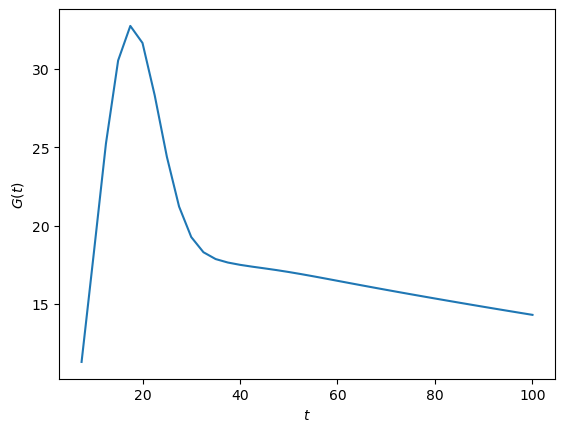

In [12]:
plt.plot(times,-np.array(gains))
plt.ylabel(r'$G(t)$')
plt.xlabel(r'$t$')

At the final time $G(t)$ was calculated the velocity profiles are

Text(0.5, 1.0, '$\\mathbf{u}_T$')

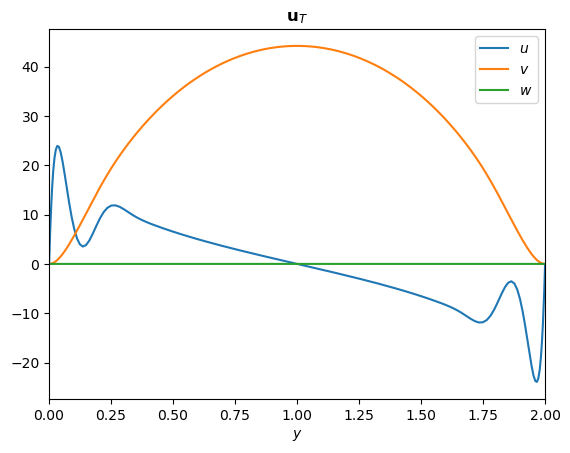

In [13]:
plt.plot(y,u['g'].real,label=r'$u$')
plt.plot(y,v['g'].real,label=r'$v$')
plt.plot(y,w['g'].real,label=r'$w$')
plt.legend()
plt.xlabel(r'$y$')
plt.xlim([0,2])
plt.title(r'$\mathbf{u}_T$')

(0.0, 2.0)

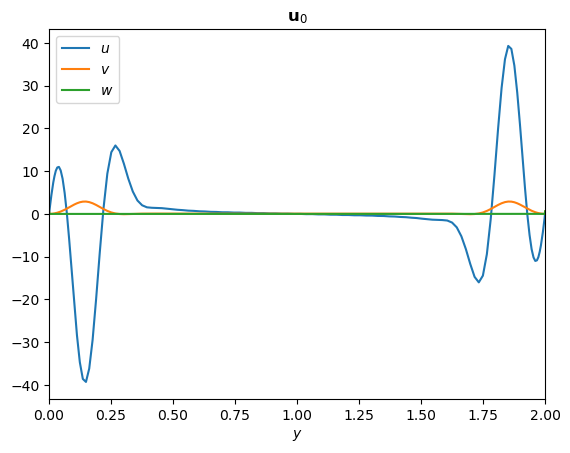

In [14]:
velocity = sol.x
u['g'] = velocity[:Ny]+1j*velocity[Ny:2*Ny]
v['g'] = velocity[2*Ny:3*Ny]+1j*velocity[3*Ny:4*Ny]
w['g'] = velocity[4*Ny:5*Ny]+1j*velocity[5*Ny:6*Ny]
plt.plot(y,u['g'].real,label=r'$u$')
plt.plot(y,v['g'].real,label=r'$v$')
plt.plot(y,w['g'].real,label=r'$w$')
plt.legend()
plt.title(r'$\mathbf{u}_0$')
plt.xlabel(r'$y$')
plt.xlim([0,2])

## Taylor test
Because $\mathcal{J}(\mathbf{u}_0+\epsilon \mathbf{u}')=\mathcal{J}(\mathbf{u}_0)+\epsilon \mathbf{\nabla J} \cdot \mathbf{u}' + \mathcal{O}(\epsilon^2)$. We can check that $|\mathcal{J}(\mathbf{u}_0+\epsilon \mathbf{u}')-\mathcal{J}(\mathbf{u}_0)-\epsilon \mathbf{\nabla J} \cdot \mathbf{u}'|$ decays at a second order rate.

In [15]:
forcing0 = np.random.rand(Ny*2*3)
forcingp = np.random.rand(Ny*2*3)
cost0,grad0 = directAdjointLoop(forcing0,100)

eps = 0.001
costs = []
size = []
for i in range(10):
    costp,gradp = directAdjointLoop(forcing0+eps*forcingp,100)
    costs.append(costp)
    size.append(eps)
    eps /= 2

2023-05-08 14:15:23,799 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:15:23,801 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:15:23,892 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:15:23,892 solvers 0/1 INFO :: Final iteration: 100
2023-05-08 14:15:23,893 solvers 0/1 INFO :: Final sim time: 50.0
2023-05-08 14:15:23,894 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04668 sec
2023-05-08 14:15:23,895 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01444 sec
2023-05-08 14:15:23,895 solvers 0/1 INFO :: Run time (iter 10-end): 0.07646 sec
2023-05-08 14:15:23,896 solvers 0/1 INFO :: CPU time (iter 10-end): 2.124e-05 cpu-hr
2023-05-08 14:15:23,897 solvers 0/1 INFO :: Speed: 2.439e+06 mode-stages/cpu-sec
2023-05-08 14:15:23,898 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:15:23,899 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:15:24,297 solv

2023-05-08 14:15:27,282 solvers 0/1 INFO :: Run time (iter 10-end): 0.07329 sec
2023-05-08 14:15:27,283 solvers 0/1 INFO :: CPU time (iter 10-end): 2.036e-05 cpu-hr
2023-05-08 14:15:27,284 solvers 0/1 INFO :: Speed: 2.545e+06 mode-stages/cpu-sec
2023-05-08 14:15:27,284 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-08 14:15:27,285 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-08 14:15:27,684 solvers 0/1 INFO :: Final iteration: 0
2023-05-08 14:15:27,685 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-08 14:15:27,686 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04465 sec
2023-05-08 14:15:27,686 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-08 14:15:27,732 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-08 14:15:27,734 __main__ 0/1 INFO :: Starting main loop
2023-05-08 14:15:27,821 solvers 0/1 INFO :: Stop iteration reached.
2023-05-08 14:1

In [16]:
first = np.abs(np.array(costs)-cost0)
second = np.abs(np.array(costs)-cost0 - np.array(size)*np.vdot(grad0,forcingp))

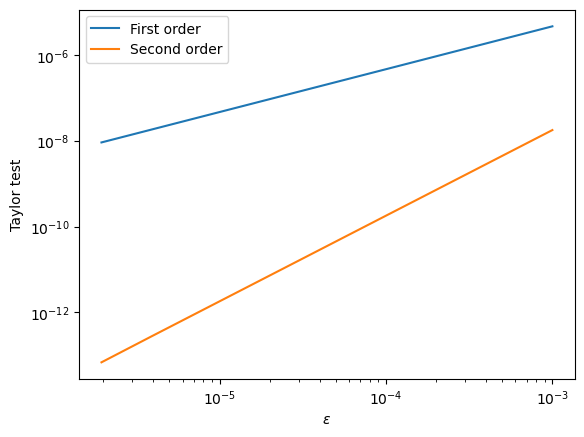

In [17]:
plt.loglog(size,first,label=r'First order')
plt.loglog(size,second,label=r'Second order')
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'Taylor test')
plt.legend()

In [18]:
from scipy.stats import linregress
print('######## Taylor Test Results ########')
print('First order  : ',linregress(np.log(size), np.log(first)).slope)
print('Second order : ',linregress(np.log(size), np.log(second)).slope)
print('#####################################')

######## Taylor Test Results ########
First order  :  1.0004652180119873
Second order :  2.000674844257717
#####################################
